In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib
from adtk.detector import ThresholdAD
from adtk.visualization import plot
import statsmodels.api as sm
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import ExponentialSmoothing
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from fbprophet.plot import add_changepoints_to_plot
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [72]:
def sesonal(data):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.month.unique()):
        plt.plot(list(range(1,len(data[data.index.month==y])+1)), data[data.index.month==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

In [73]:
def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

In [74]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [75]:
data = pd.read_csv('data_prots.csv', sep=';')

In [76]:
data.head()

Дата  Код Товара  Оборот шт Оборот руб за вычетом скидки  \
0  01.01.2019     7802656          1                       149,00   
1  01.01.2019     7811806          1                       134,00   
2  01.01.2019     7811817          2                       269,00   
3  01.01.2019     7812000          1                        84,00   
4  01.01.2019     7812289          1                       287,10   

  Валовый % скидки  
0            0,53%  
1            0,37%  
2            0,00%  
3           37,55%  
4            0,07%

In [77]:
data21 = data[data['Дата'] >= '2020-01-01'].reset_index(drop=True)

In [78]:
data21.head()

Дата  Код Товара  Оборот шт Оборот руб за вычетом скидки  \
0  21.01.2019     7802639         64                     8 518,70   
1  21.01.2019     7802641         30                     3 973,40   
2  21.01.2019     7802643         41                     5 863,10   
3  21.01.2019     7802655          2                       205,40   
4  21.01.2019     7802656         48                     6 545,30   

  Валовый % скидки  
0            8,46%  
1            9,14%  
2            1,57%  
3           16,50%  
4            5,57%

In [79]:
data.dtypes

Дата                            object
Код Товара                       int64
Оборот шт                        int64
Оборот руб за вычетом скидки    object
Валовый % скидки                object
dtype: object

In [80]:
data = data.rename(columns={'Код Товара':'product_code', 'Дата':'date', 
                            'Оборот шт':'turnoverOfGoods', 
                            'Оборот руб за вычетом скидки':'turnoverWithDisc', 
                            'Валовый % скидки':'percentOfDisc'}) 

In [81]:
data

date  product_code  turnoverOfGoods turnoverWithDisc  \
0       01.01.2019       7802656                1           149,00   
1       01.01.2019       7811806                1           134,00   
2       01.01.2019       7811817                2           269,00   
3       01.01.2019       7812000                1            84,00   
4       01.01.2019       7812289                1           287,10   
...            ...           ...              ...              ...   
207961  31.12.2021       7829750                9         1 665,00   
207962  31.12.2021       7830032                9         1 780,00   
207963  31.12.2021       7831273                3         1 341,00   
207964  31.12.2021       7831274                2           885,70   
207965  31.12.2021       7831275                3         1 275,60   

       percentOfDisc  
0              0,53%  
1              0,37%  
2              0,00%  
3             37,55%  
4              0,07%  
...              ...  
207961         0,00%  
207962         5,37%  
207963         0,00%  
207964         0,00%  
207965         7,18%  

[207966 rows x 5 columns]

In [82]:
data['percentOfDisc'] = data['percentOfDisc'].str.replace('%', '').str.replace(',', '.')
data['turnoverWithDisc'] = data['turnoverWithDisc'].str.replace(',', '.').str.replace(' ', '')
data = data.astype({'percentOfDisc':'float', 'turnoverWithDisc':'float', 'date':'datetime64[ns]'})

In [83]:
data.head()

date  product_code  turnoverOfGoods  turnoverWithDisc  percentOfDisc
0 2019-01-01       7802656                1             149.0           0.53
1 2019-01-01       7811806                1             134.0           0.37
2 2019-01-01       7811817                2             269.0           0.00
3 2019-01-01       7812000                1              84.0          37.55
4 2019-01-01       7812289                1             287.1           0.07

In [84]:
data21

Дата  Код Товара  Оборот шт Оборот руб за вычетом скидки  \
0      21.01.2019     7802639         64                     8 518,70   
1      21.01.2019     7802641         30                     3 973,40   
2      21.01.2019     7802643         41                     5 863,10   
3      21.01.2019     7802655          2                       205,40   
4      21.01.2019     7802656         48                     6 545,30   
...           ...         ...        ...                          ...   
71639  31.12.2021     7829750          9                     1 665,00   
71640  31.12.2021     7830032          9                     1 780,00   
71641  31.12.2021     7831273          3                     1 341,00   
71642  31.12.2021     7831274          2                       885,70   
71643  31.12.2021     7831275          3                     1 275,60   

      Валовый % скидки  
0                8,46%  
1                9,14%  
2                1,57%  
3               16,50%  
4                5,57%  
...                ...  
71639            0,00%  
71640            5,37%  
71641            0,00%  
71642            0,00%  
71643            7,18%  

[71644 rows x 5 columns]

In [85]:
data.dtypes

date                datetime64[ns]
product_code                 int64
turnoverOfGoods              int64
turnoverWithDisc           float64
percentOfDisc              float64
dtype: object

In [86]:
df = data.groupby('date', as_index=False) \
    .agg({'turnoverOfGoods':'sum'})

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f863a6c1f10> has a label of '_nolegend_' which cannot be automatically added to the legend.



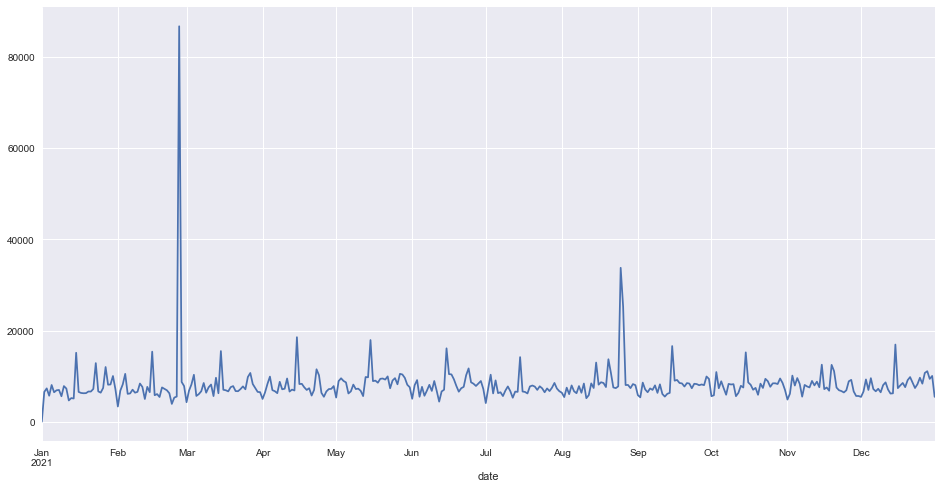

In [87]:
df[df['date'] >= '2021-01-01'].plot(x='date', y='turnoverOfGoods', label='_nolegend_');

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f864a870dc0> has a label of '_nolegend_' which cannot be automatically added to the legend.



Text(0, 0.5, 'Оборот товаров, шт')

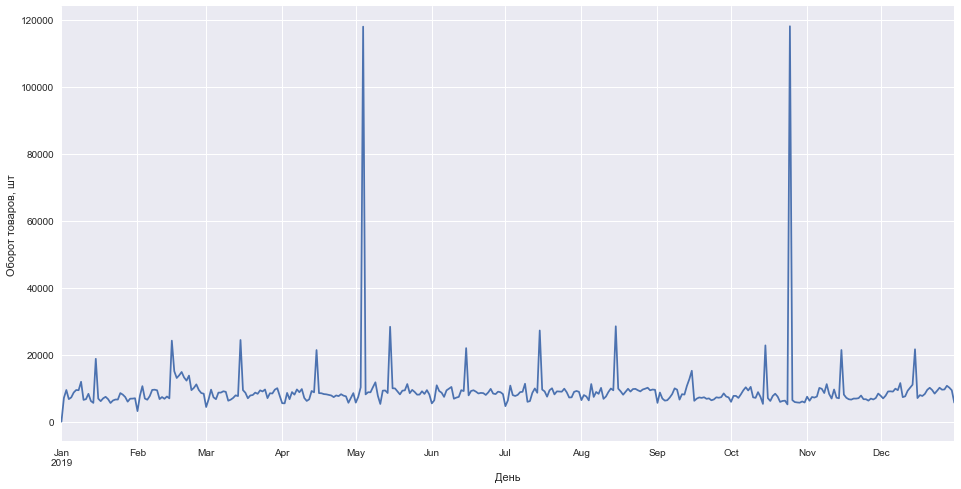

In [88]:
df[df['date'] <= '2020-01-01'].plot(x='date', y='turnoverOfGoods', label='_nolegend_');
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')

In [89]:
df[df['date'] <= '2020-01-01'].to_excel('mydata.xlsx', index=False)

In [90]:
df

date  turnoverOfGoods
0   2019-01-01               25
1   2019-01-02             7115
2   2019-01-03             9469
3   2019-01-04             6744
4   2019-01-05             7257
..         ...              ...
725 2021-12-27            10699
726 2021-12-28            11086
727 2021-12-29             9400
728 2021-12-30            10043
729 2021-12-31             5464

[730 rows x 2 columns]

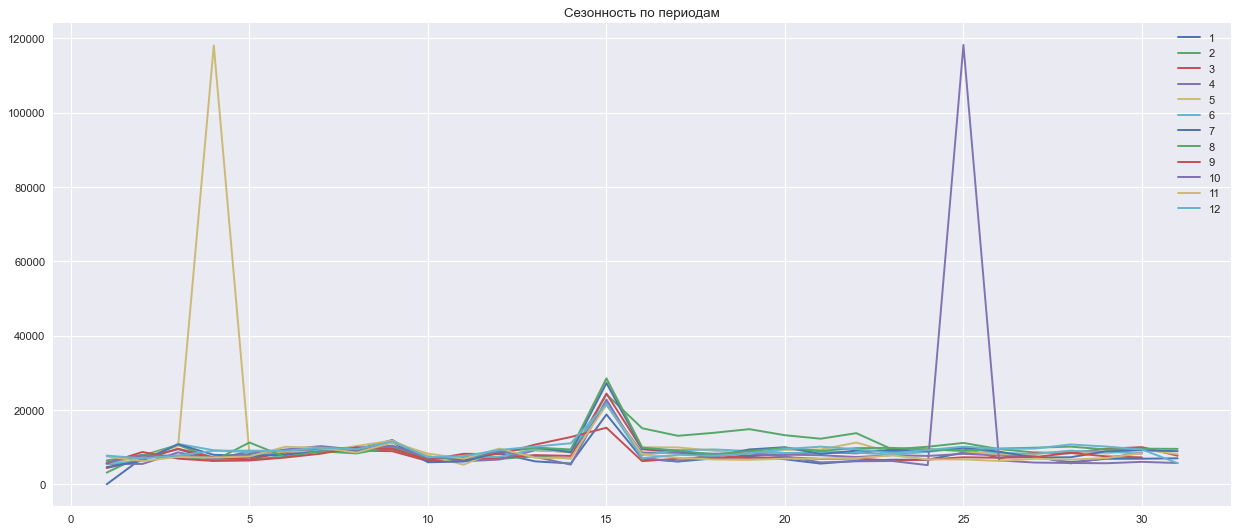

In [91]:
sesonal(df[df['date'] <= '2020-01-01'].set_index('date'))

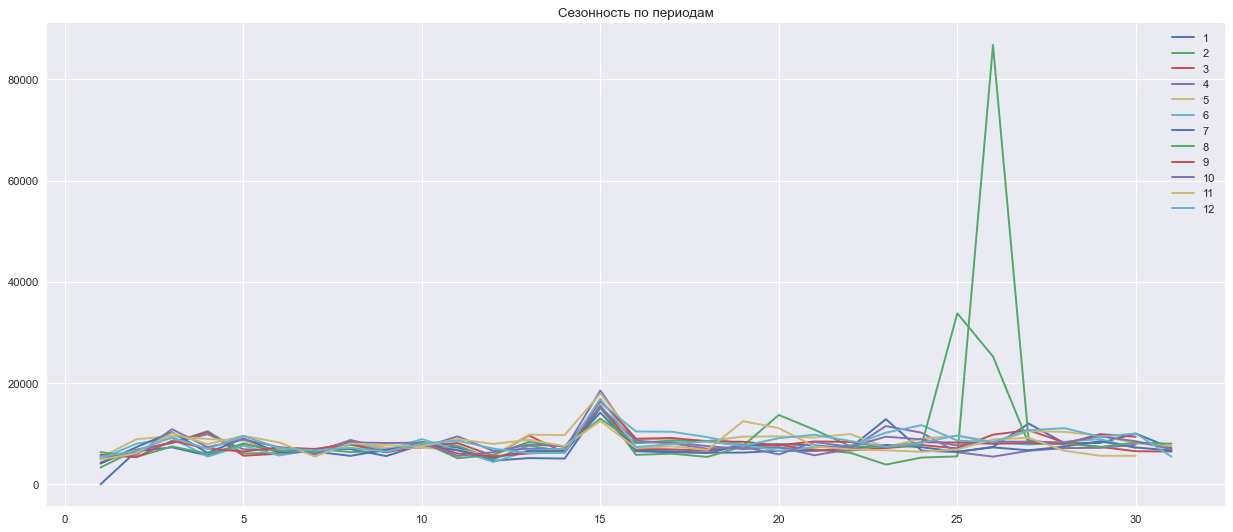

In [92]:
sesonal(df[df['date'] >= '2021-01-01'].set_index('date'))

---
## Описательные статистики

In [93]:
df19 = df[df['date'] <= '2020-01-01']
df21 = df[df['date'] >= '2020-01-01']

In [94]:
df19.describe()

turnoverOfGoods
count       365.000000
mean       9317.306849
std        8697.539892
min          25.000000
25%        7073.000000
50%        8287.000000
75%        9417.000000
max      118198.000000

In [25]:
df21.describe()

turnoverOfGoods
count       365.000000
mean       8151.841096
std        4924.899476
min          15.000000
25%        6605.000000
50%        7506.000000
75%        8508.000000
max       86775.000000

In [26]:
df21.head()

date  turnoverOfGoods
365 2021-01-01               15
366 2021-01-02             6538
367 2021-01-03             7312
368 2021-01-04             5699
369 2021-01-05             8054

---
#### Анализ оборота товаров в магазинах по месяцам

In [27]:
df21_copy = df21.copy()

In [28]:
df21_copy['month'] = df21_copy['date'].dt.month

In [29]:
df21_copy.head()

date  turnoverOfGoods  month
365 2021-01-01               15      1
366 2021-01-02             6538      1
367 2021-01-03             7312      1
368 2021-01-04             5699      1
369 2021-01-05             8054      1

In [30]:
df21_copy_month = df21_copy.groupby('month', as_index=False) \
                                        .agg({'turnoverOfGoods':'sum'}) \
                                            .rename(columns={'turnoverOfGoods':'turnoverOfGoodsMonth'})
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'June', 7:'July', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df21_copy_month['month'] = months.values()
df21_copy_month

month  turnoverOfGoodsMonth
0    Jan                223250
1    Feb                274776
2    Mar                236079
3    Apr                234586
4    May                271451
5   June                243329
6   July                224468
7    Aug                287271
8   Sept                237773
9    Oct                247843
10   Nov                236970
11   Dec                257626

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <BarContainer object of 12 artists> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


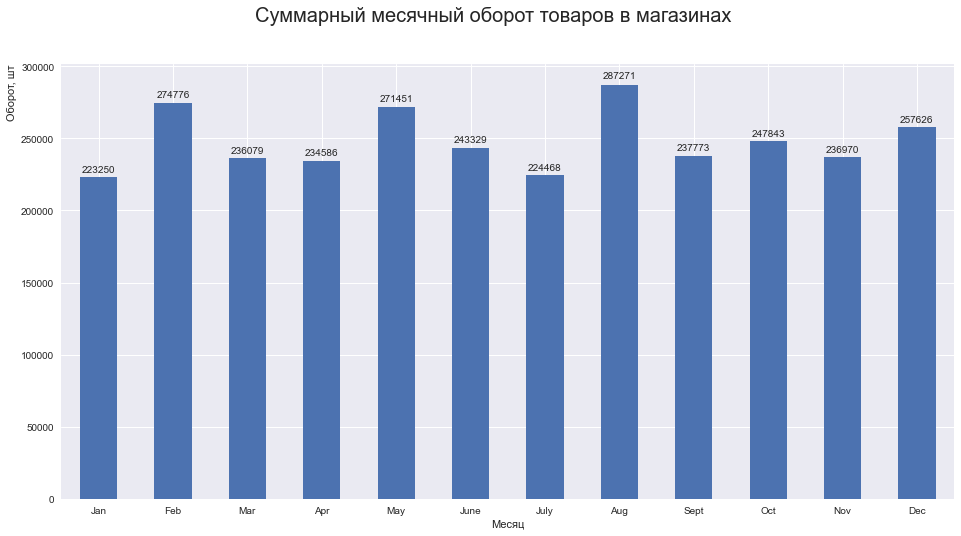

In [31]:
df21_copy_month.plot(x='month', y='turnoverOfGoodsMonth', kind='bar', label='_nolegend_');
plt.suptitle('Суммарный месячный оборот товаров в магазинах', fontsize=20);
plt.xlabel('Месяц', loc='center');
plt.ylabel('Оборот, шт', loc='top');
plt.xticks(rotation = -360);
ax = plt.gca();
autolabel(ax.patches, df21_copy_month['turnoverOfGoodsMonth'], height_factor=1.01);

---
#### Анализ оборота товаров в магазинах по дням недели

In [32]:
df21_copy['weekday'] = df21_copy['date'].dt.weekday

In [33]:
df21_copy_weekday = df21_copy.groupby('weekday', as_index=False) \
                                        .agg({'turnoverOfGoods':'mean'}) \
                                            .rename(columns={'turnoverOfGoods':'turnoverOfGoodsMean'})
weekdays = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df21_copy_weekday['weekday'] = weekdays.values()
df21_copy_weekday['turnoverOfGoodsMean'] = round(df21_copy_weekday['turnoverOfGoodsMean'])
df21_copy_weekday = df21_copy_weekday.astype({'turnoverOfGoodsMean':'int'})
df21_copy_weekday

weekday  turnoverOfGoodsMean
0     Mon                 7504
1     Tue                 7433
2     Wed                 8357
3     Thu                 8317
4     Fri                 9616
5     Sat                 8296
6     Sun                 7513

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <BarContainer object of 7 artists> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


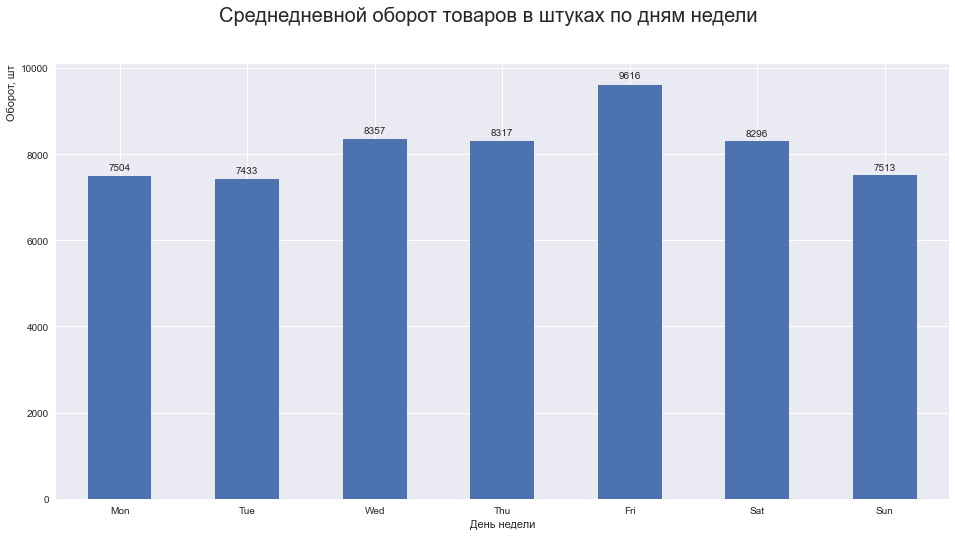

In [34]:
df21_copy_weekday.plot(x='weekday', y='turnoverOfGoodsMean', kind='bar', label='_nolegend_');
plt.suptitle('Среднедневной оборот товаров в штуках по дням недели', fontsize=20);
plt.xlabel('День недели', loc='center');
plt.ylabel('Оборот, шт', loc='top');
plt.xticks(rotation = -360);

ax = plt.gca()
autolabel(ax.patches, df21_copy_weekday['turnoverOfGoodsMean'], height_factor=1.01)

---
## Аномальные значения

- 2019 год

Text(0, 0.5, 'Оборот товаров, шт')

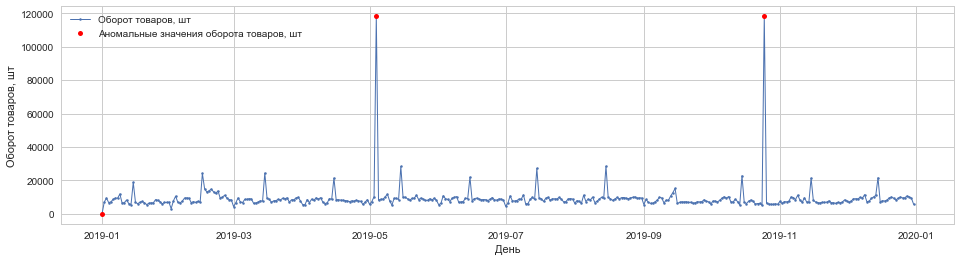

In [35]:
threshold_ad = ThresholdAD(high=30000, low=1000)
anomalies = threshold_ad.detect(df19.set_index('date'))
plot(df19.set_index('date'), anomaly=anomalies, ts_linewidth=1, ts_markersize=5, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.legend(('Оборот товаров, шт', 'Аномальные значения оборота товаров, шт'))
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')

In [36]:
df19.loc[:1]

date  turnoverOfGoods
0 2019-01-01               25
1 2019-01-02             7115

- 2021 год

Text(0, 0.5, 'Оборот товаров, шт')

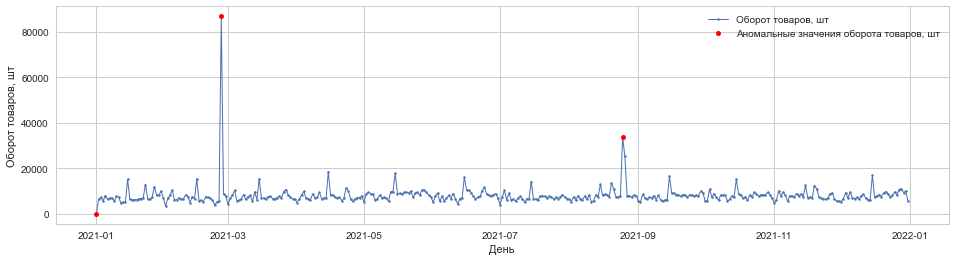

In [37]:
threshold_ad = ThresholdAD(high=30000, low=1000)
anomalies = threshold_ad.detect(df21.set_index('date'))
plot(df21.set_index('date'), anomaly=anomalies, ts_linewidth=1, ts_markersize=5, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.legend(('Оборот товаров, шт', 'Аномальные значения оборота товаров, шт'))
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')

In [38]:
df19.loc[:2]

date  turnoverOfGoods
0 2019-01-01               25
1 2019-01-02             7115
2 2019-01-03             9469

Анамально высокие и низкие значения уровне ряда продаж товаров стоит обработать. Низкое значение продаж 1го января каждого года, вероятно, связано с празднованием Нового года. Аномально высокие значения объемов продаж, вероятно, можно связать с "Черной пятницей" либо установлением акционных цен на товары в связи с другой акционной кампанией.

Аномально высокие и низкие значения объемов продаж заменим на величины, равные сумме объемов продаж на данное число всех месяцев года, за исключением данного, деленной на 11.

---
### Обработка аномальных значений 2019 года

In [39]:
df19.loc[0, 'turnoverOfGoods'] = round(df19[df19['date'].dt.day == 1].loc[1:]['turnoverOfGoods'].mean());

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [40]:
df19.loc[123, 'turnoverOfGoods'] = round(df19[(df19['date'].dt.day == 4) & (df19['date'].dt.month != 5)]['turnoverOfGoods'].mean())

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [41]:
df19.loc[297, 'turnoverOfGoods'] = round(df19[(df19['date'].dt.day == 25) & (df19['date'].dt.month != 10)]['turnoverOfGoods'].mean())

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa2792e2250> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


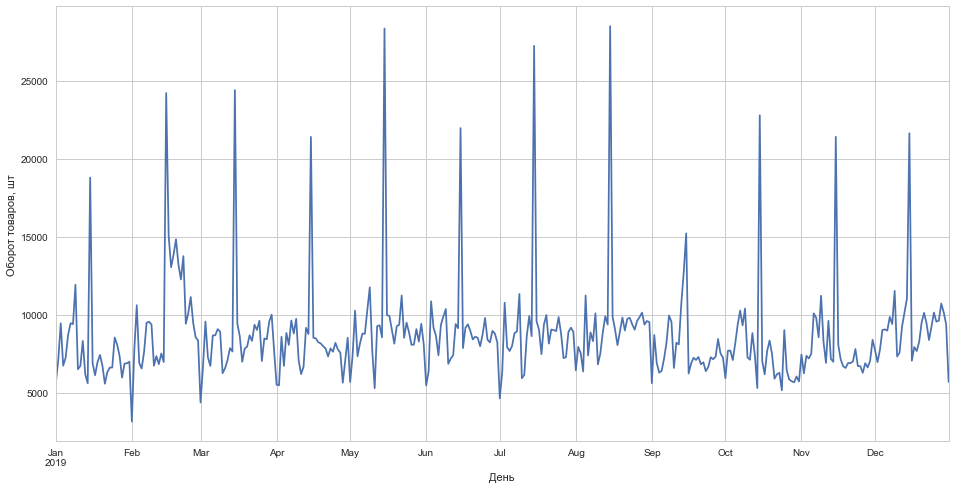

In [42]:
df19.plot(x='date', y='turnoverOfGoods', label='_nolegend_')
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт');

---
### Обработка аномальных значений 2021 года

In [95]:
df21.reset_index(drop=True, inplace=True)

In [96]:
df21.loc[0, 'turnoverOfGoods'] = round(df21[df21['date'].dt.day == 1].loc[1:]['turnoverOfGoods'].mean());

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
df21.loc[56, 'turnoverOfGoods'] = round(df21[(df21['date'].dt.day == 26) & (df21['date'].dt.month != 2)]['turnoverOfGoods'].mean())

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
df21.loc[235:]

date  turnoverOfGoods
235 2021-08-24             7752
236 2021-08-25            33770
237 2021-08-26            25249
238 2021-08-27             8047
239 2021-08-28             8065
..         ...              ...
360 2021-12-27            10699
361 2021-12-28            11086
362 2021-12-29             9400
363 2021-12-30            10043
364 2021-12-31             5464

[130 rows x 2 columns]

In [99]:
df21.loc[236, 'turnoverOfGoods'] = round(df21[(df21['date'].dt.day == 25) & (df21['date'].dt.month != 8)]['turnoverOfGoods'].mean())

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
df21.loc[237, 'turnoverOfGoods'] = round(df21[(df21['date'].dt.day == 26) & (df21['date'].dt.month != 8)]['turnoverOfGoods'].mean())

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f861ffccd60> has a label of '_nolegend_' which cannot be automatically added to the legend.



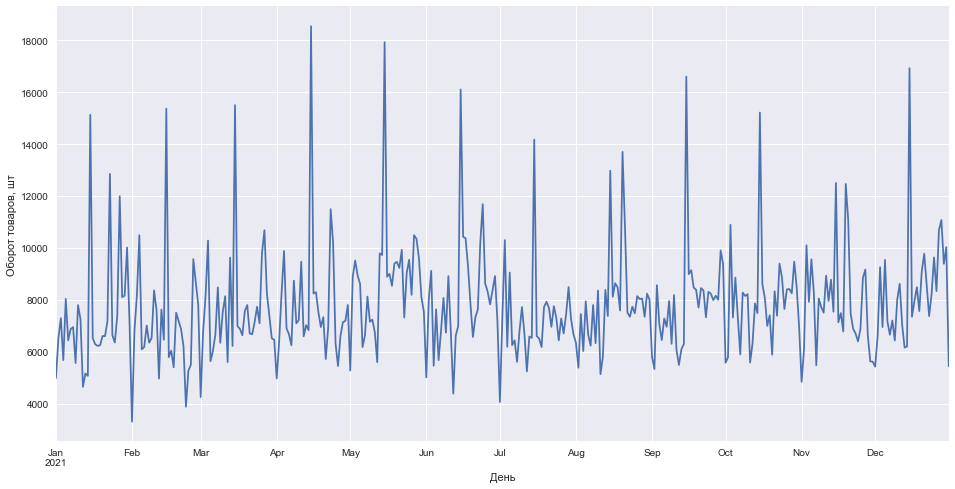

In [101]:
df21.plot(x='date', y='turnoverOfGoods', label='_nolegend_')
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт');

In [102]:
def sesonal(data):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.month.unique()):
        plt.plot(list(range(1,len(data[data.index.month==y])+1)), data[data.index.month==y][data.columns[0]].values, label=y)
    # plt.title("Сезонность по месяцам", size=20)
    plt.legend(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], loc="best")
    plt.xlabel('День', size=18)
    plt.ylabel('Оборот товаров, шт', size=18)
    plt.show()

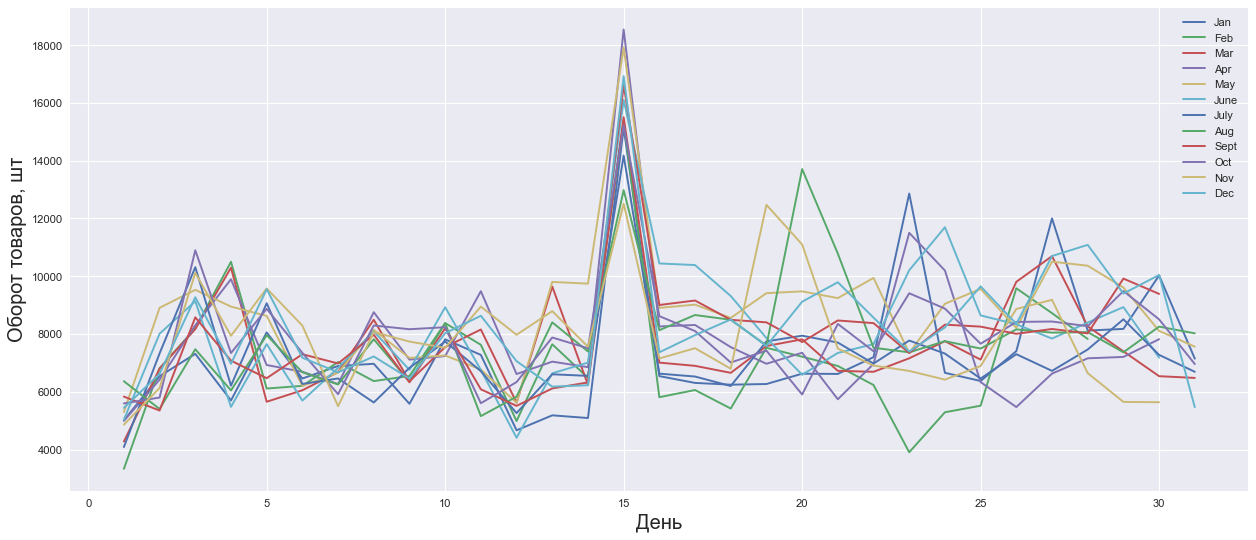

In [103]:
sesonal(df21.set_index('date'))

---
## Проверка рядов на стационарность

- 2019

In [39]:
test = sm.tsa.adfuller(df19['turnoverOfGoods'])
print(f'adf: {round(test[0], 4)}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -19.127
p-value: 0.0
Critical values: {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}
единичных корней нет, ряд стационарен


- 2021

In [40]:
test = sm.tsa.adfuller(df21['turnoverOfGoods'])
print(f'adf: {round(test[0], 4)}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -5.4445
p-value: 2.7297378738056837e-06
Critical values: {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
единичных корней нет, ряд стационарен


---
## Анализ коррелограмм (автокорреляция и частичная автокорреляция)

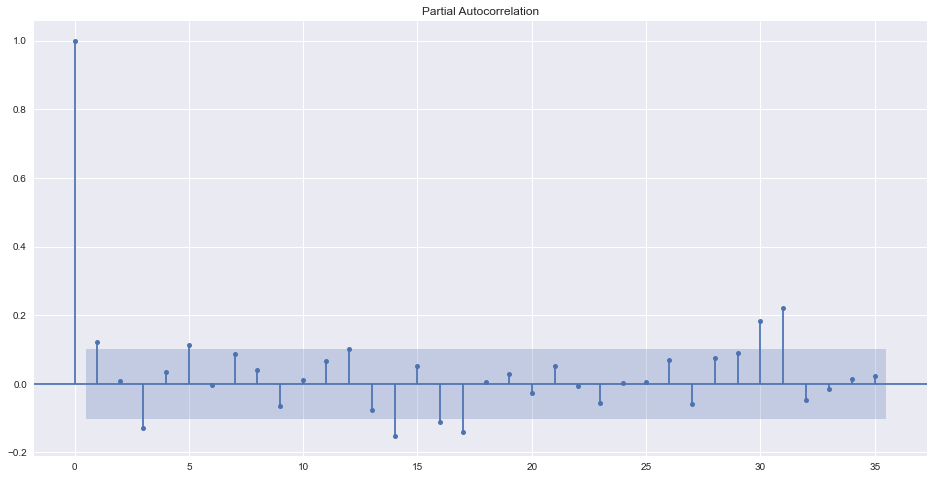

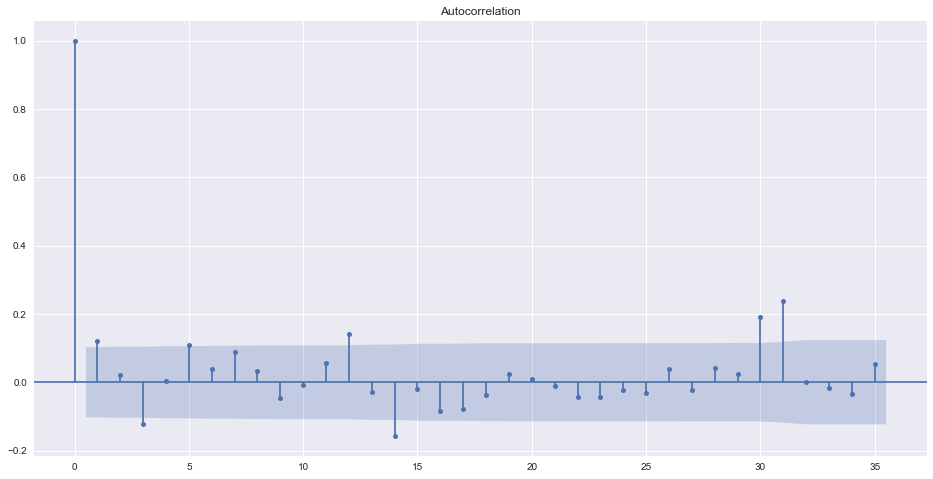

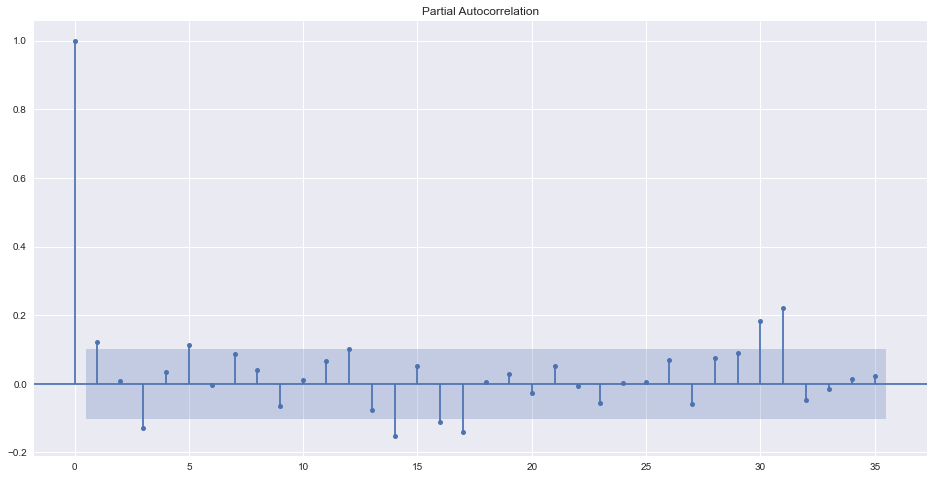

In [45]:
plot_acf(df21['turnoverOfGoods'], lags=35)
plot_pacf(df21['turnoverOfGoods'], lags=35)

In [42]:
df21_copy = df21.copy()

In [43]:
df21_copy['MA'] = df21_copy['turnoverOfGoods'].rolling(30).mean()

In [42]:
def custom_legend_name(new_names):
    for i, new_name in enumerate(new_names):
        fig.data[i].name = new_name

In [520]:
# template = 'plotly_dark', 
fig = px.line(df21_copy, x="date", y=["turnoverOfGoods", "MA"], labels={'value' : 'Оборот товаров, шт', 'date': 'День'})
fig.update_layout(legend_title='', legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),  font=dict(
        family="Arial",
        size=13
    ))
custom_legend_name(['Оборот товаров, шт', 'Сглаженный ряд'])
fig.show()

---
## Модель 1
## Начальная модель ARMA

In [159]:
d21 = df21.set_index('date')[['turnoverOfGoods']]

In [432]:
d21_train_1 = d21[:273]
d21_test_1 = d21[273:]

In [433]:
model_1 = sm.tsa.ARMA(d21_train_1, order=(1,1)).fit() 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarni

In [434]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        turnoverOfGoods   No. Observations:                  273
Model:                     ARMA(1, 1)   Log Likelihood               -2478.969
Method:                       css-mle   S.D. of innovations           2124.943
Date:                Fri, 08 Apr 2022   AIC                           4965.937
Time:                        13:15:19   BIC                           4980.375
Sample:                    01-01-2021   HQIC                          4971.733
                         - 09-30-2021                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7755.6011    149.285     51.952      0.000    7463.008    8048.194
ar.L1.turnoverOfGoods     0.1882      0.273      0.690      0.490      -0.347       0.723
ma.L1.turnoverOfGoods    -0.0570      0.273     -0.209      0.834      -0.592       0.478
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.3149           +0.0000j            5.3149            0.0000
MA.1           17.5338           +0.0000j           17.5338            0.0000
-----------------------------------------------------------------------------
"""

In [435]:
import datetime as DT
import pandas as pd

start_date = DT.datetime(2021, 10, 1)
end_date = DT.datetime(2021, 12, 31)

res_time = pd.date_range(
    min(start_date, end_date),
    max(start_date, end_date)
).strftime("%Y-%m-%d").tolist()

In [436]:
from statsmodels.tsa.arima_model import _arma_predict_out_of_sample

params = model_1.params
residuals = model_1.resid
p = model_1.k_ar
q = model_1.k_ma
k_exog = model_1.k_exog
k_trend = model_1.k_trend
steps = 92

pred_1 = _arma_predict_out_of_sample(params, steps, residuals, p, q, k_trend, k_exog, endog=d21_train_1, exog=None, start=len(d21_train_1))


In [134]:
pred_1 = pd.DataFrame(res_time, pred_1).reset_index().rename(columns={'index':'turnoverOfGoods', 0:'date'})
pred_1 = pred_1.astype({'date':'datetime64[ns]'}).set_index('date')

In [135]:
pred_1

turnoverOfGoods
date                       
2021-10-01      7985.931452
2021-10-02      7798.937871
2021-10-03      7763.754939
2021-10-04      7757.135254
2021-10-05      7755.889757
...                     ...
2021-12-27      7755.601106
2021-12-28      7755.601106
2021-12-29      7755.601106
2021-12-30      7755.601106
2021-12-31      7755.601106

[92 rows x 1 columns]

In [120]:
pred_1.astype({'date':'datetime64[ns]'})

turnoverOfGoods       date
0       7985.931452 2021-01-10
1       7798.937871 2021-02-10
2       7763.754939 2021-03-10
3       7757.135254 2021-04-10
4       7755.889757 2021-05-10
..              ...        ...
87      7755.601106 2021-12-27
88      7755.601106 2021-12-28
89      7755.601106 2021-12-29
90      7755.601106 2021-12-30
91      7755.601106 2021-12-31

[92 rows x 2 columns]

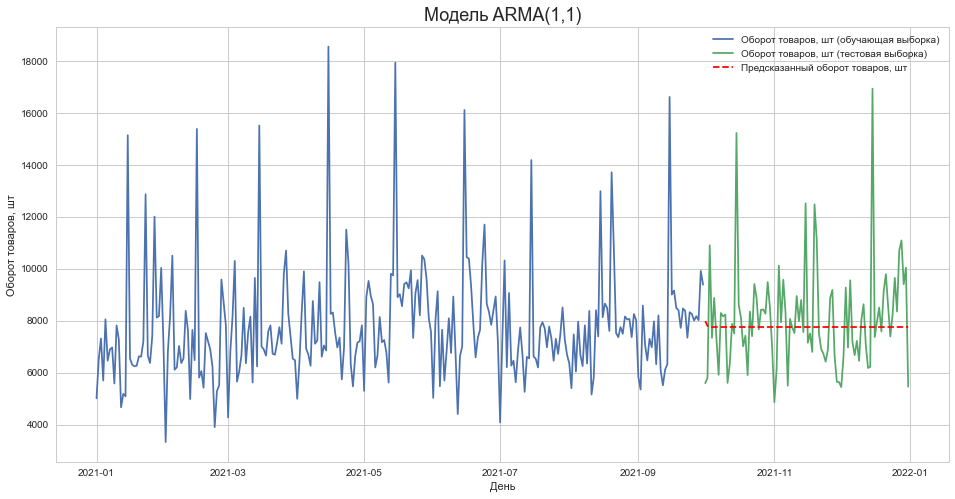

In [136]:
plt.plot(d21_train_1);
plt.plot(d21_test_1);
plt.plot(pred_1, 'r--');
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель ARMA(1,1)', size=18);

---
### Анализ остатков модели

In [364]:
d21['turnoverOfGoods']

date
2021-01-01     5011
2021-01-02     6538
2021-01-03     7312
2021-01-04     5699
2021-01-05     8054
              ...  
2021-12-27    10699
2021-12-28    11086
2021-12-29     9400
2021-12-30    10043
2021-12-31     5464
Name: turnoverOfGoods, Length: 365, dtype: int64

In [365]:
pred

2021-01-01    7833.375982
2021-01-02    7491.348685
2021-01-03    7670.309494
2021-01-04    7767.264605
2021-01-05    7574.068375
                 ...     
2021-12-27    7899.993441
2021-12-28    8181.106356
2021-12-29    8233.195443
2021-12-30    8030.327418
2021-12-31    8104.247488
Freq: D, Length: 365, dtype: float64

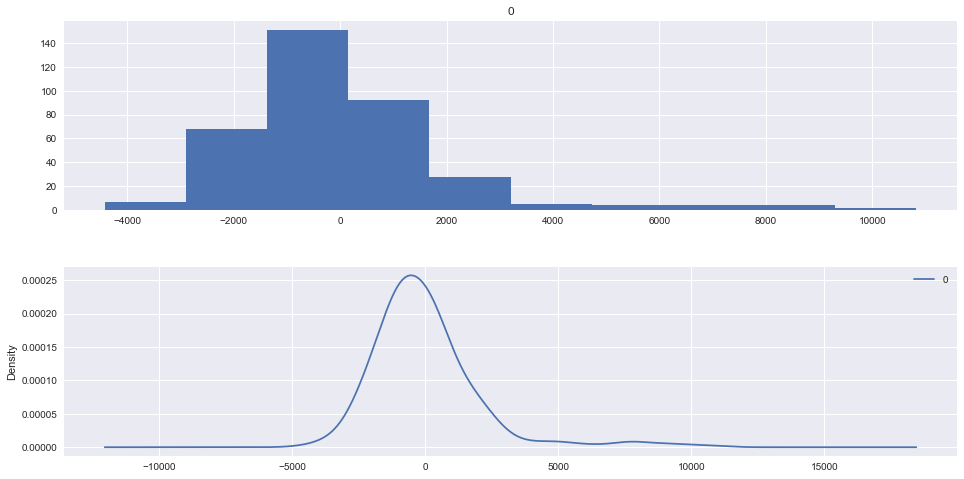

In [366]:
residuals = [d21['turnoverOfGoods'][i]-pred[i] for i in range(len(d21))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


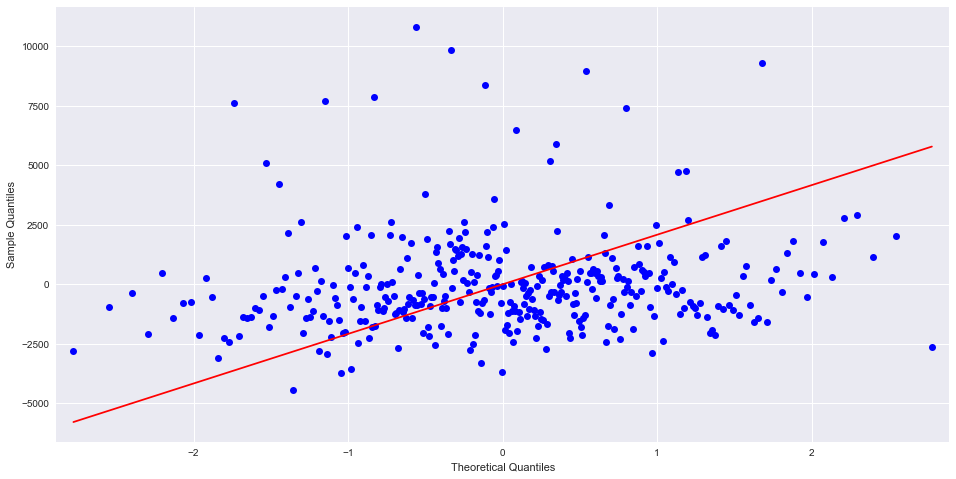

In [367]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='s');
plt.show();

In [368]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0) – данные распределены нормально')
else:
	print('Sample does not look Gaussian (reject H0) – данные распределены ненормально')

Statistics=0.841, p=0.000
Sample does not look Gaussian (reject H0) – данные распределены ненормально


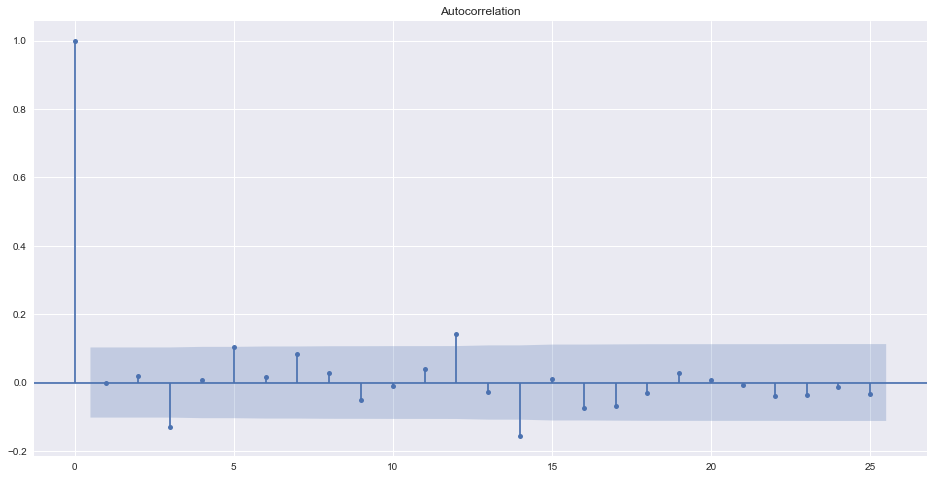

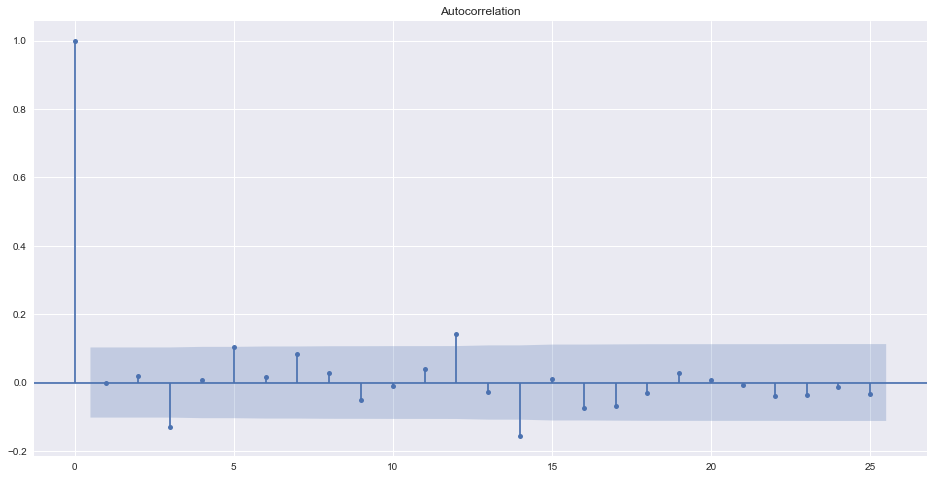

In [369]:
plot_acf(residuals, lags=25)

---
### Декомпозиция временного ряда (2021 г)

<ipython-input-295-2c9adf4136eb>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_M = seasonal_decompose(df21.set_index('date')[['turnoverOfGoods']], model='multiplicative', freq=31)


Text(0.5, 0.98, 'Мультипликативная модель')

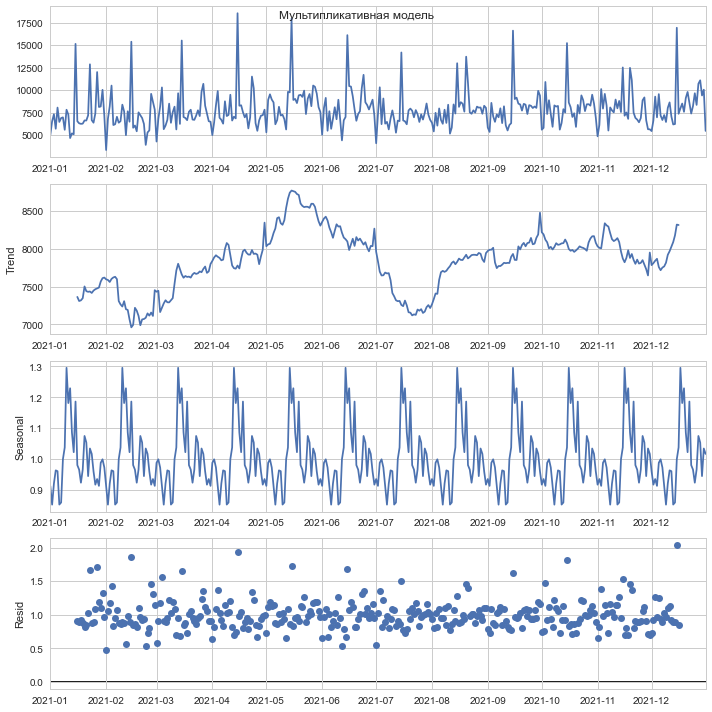

In [295]:
result_M = seasonal_decompose(df21.set_index('date')[['turnoverOfGoods']], model='multiplicative', freq=31)

plt.rcParams.update({'figure.figsize':(10,10)})
result_M.plot().suptitle('Мультипликативная модель')

---
## Модель 2
### Модель Хольта-Винтерса (тройное экспоненциальное сглаживание – учет тренда и сезонности)

In [160]:
d21_train_2 = d21[:273]
d21_test_2 = d21[273:]

In [161]:
d21_test_2

turnoverOfGoods
date                       
2021-10-01             5596
2021-10-02             5800
2021-10-03            10898
2021-10-04             7340
2021-10-05             8872
...                     ...
2021-12-27            10699
2021-12-28            11086
2021-12-29             9400
2021-12-30            10043
2021-12-31             5464

[92 rows x 1 columns]

In [441]:
model_2 = ExponentialSmoothing(d21_train_2, seasonal_periods=30, trend=None, seasonal='mul').fit()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [442]:
model_2.params

{'smoothing_level': 0.005,
 'smoothing_trend': nan,
 'smoothing_seasonal': 0.30797619047619046,
 'damping_trend': nan,
 'initial_level': 6665.5,
 'initial_trend': nan,
 'initial_seasons': array([0.75178156, 0.98087165, 1.09699197, 0.85499962, 1.20831145,
        0.96901958, 1.03398095, 1.04538294, 0.83759658, 1.17245518,
        1.09159103, 0.7000225 , 0.7777361 , 0.76363364, 2.27034731,
        0.98132173, 0.94606556, 0.93691396, 0.94036456, 0.99392394,
        0.99272373, 1.07988898, 1.92963769, 0.99857475, 0.95611732,
        1.11109444, 1.80046508, 1.21806316, 1.22661466, 1.50431325]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [472]:
pred_2 = model_2.predict(start='2021-10-01', end='2021-12-31')

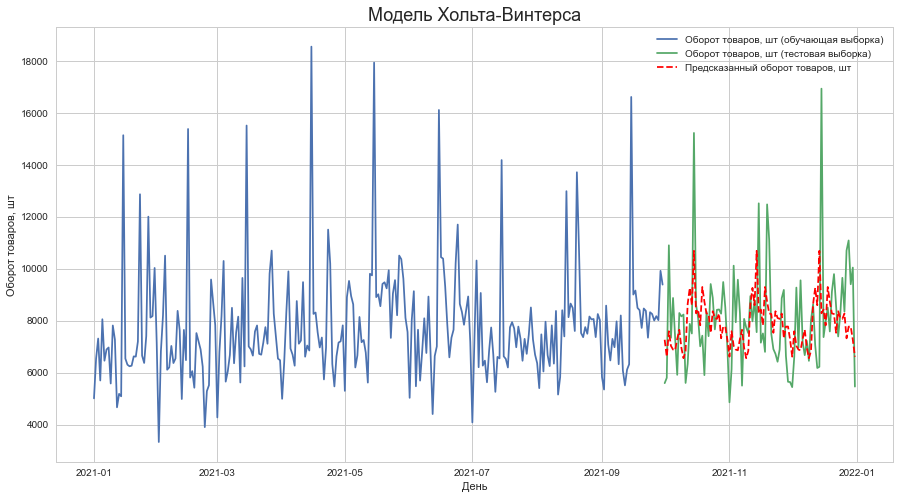

In [473]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_2);
plt.plot(d21_test_2);
plt.plot(pred_2, 'r--');
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Хольта-Винтерса', size=18);

---
## Модель 3
### Prophet (без регрессоров)

In [104]:
df21_prof = df21.copy().rename(columns={'date':'ds', 'turnoverOfGoods':'y'})

In [108]:
d21_train_3 = df21_prof[:273]
d21_test_3 = df21_prof[273:]

In [109]:
model_3 = Prophet(yearly_seasonality = True, daily_seasonality = False, seasonality_mode = 'multiplicative')
model_3.fit(d21_train_3)

In [110]:
pred_3 = model_3.make_future_dataframe(periods=92)

In [111]:
pred_3 = model_3.predict(pred_3)

In [112]:
pred_3.head()

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2021-01-01  6271.45959  4015.425333  9289.393062   6271.45959   6271.45959   
1 2021-01-02  6283.01268  4208.678671  9428.726378   6283.01268   6283.01268   
2 2021-01-03  6294.56577  3585.859851  8698.476984   6294.56577   6294.56577   
3 2021-01-04  6306.11886  3509.187162  8692.698512   6306.11886   6306.11886   
4 2021-01-05  6317.67195  3544.094488  8749.138254   6317.67195   6317.67195   

   multiplicative_terms  multiplicative_terms_lower  \
0              0.065301                    0.065301   
1              0.072221                    0.072221   
2             -0.035096                   -0.035096   
3             -0.029134                   -0.029134   
4             -0.033954                   -0.033954   

   multiplicative_terms_upper    weekly  weekly_lower  weekly_upper    yearly  \
0                    0.065301  0.042653      0.042653      0.042653  0.022649   
1                    0.072221  0.055160      0.055160      0.055160  0.017061   
2                   -0.035096 -0.047826     -0.047826     -0.047826  0.012730   
3                   -0.029134 -0.039039     -0.039039     -0.039039  0.009905   
4                   -0.033954 -0.042750     -0.042750     -0.042750  0.008796   

   yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0      0.022649      0.022649             0.0                   0.0   
1      0.017061      0.017061             0.0                   0.0   
2      0.012730      0.012730             0.0                   0.0   
3      0.009905      0.009905             0.0                   0.0   
4      0.008796      0.008796             0.0                   0.0   

   additive_terms_upper         yhat  
0                   0.0  6680.994157  
1                   0.0  6736.777937  
2                   0.0  6073.652189  
3                   0.0  6122.394039  
4                   0.0  6103.161456

In [113]:
pred_3_plt = pred_3[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

In [114]:
pred_3_interval = pred_3[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

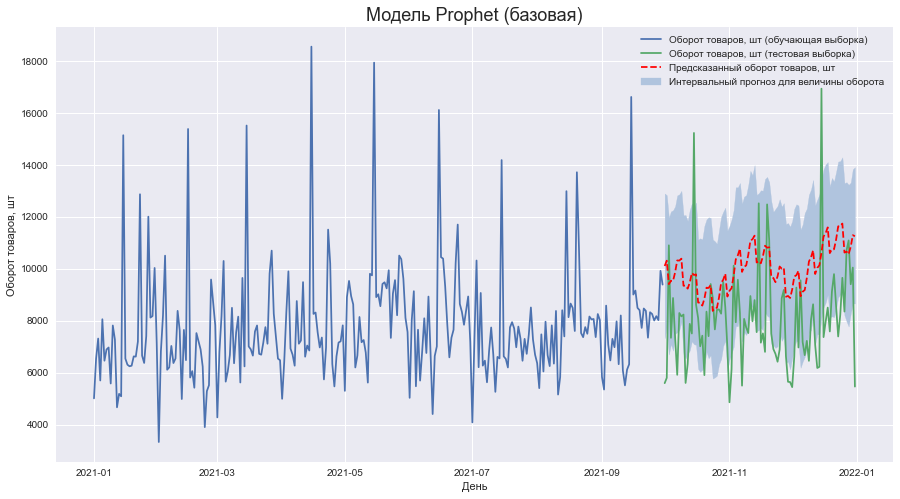

In [115]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_3['ds'], d21_train_3['y']);
plt.plot(d21_test_3['ds'], d21_test_3['y']);
plt.plot(pred_3_plt['ds'], pred_3_plt['y'], 'r--');
plt.fill_between(pred_3_interval['ds'], pred_3_interval['yhat_lower'], pred_3_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (базовая)', size=18);

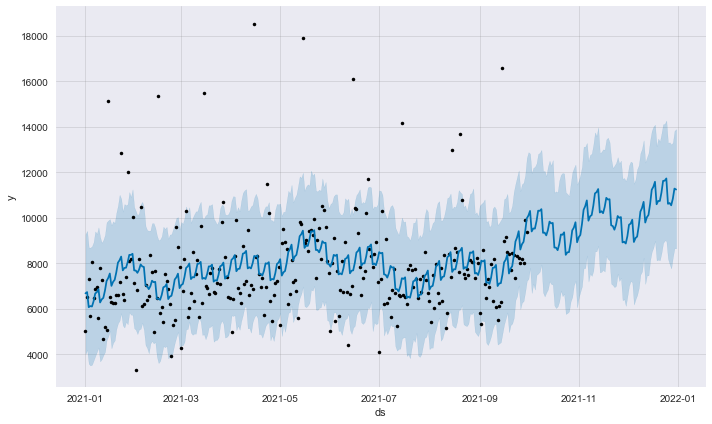

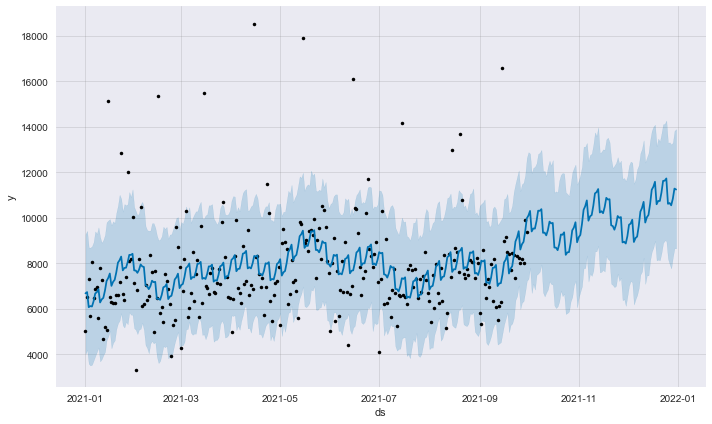

In [116]:
model_3.plot(pred_3)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



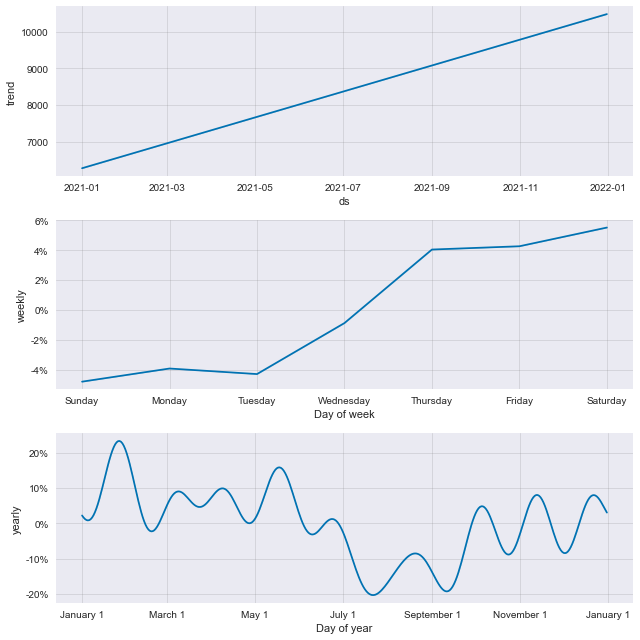

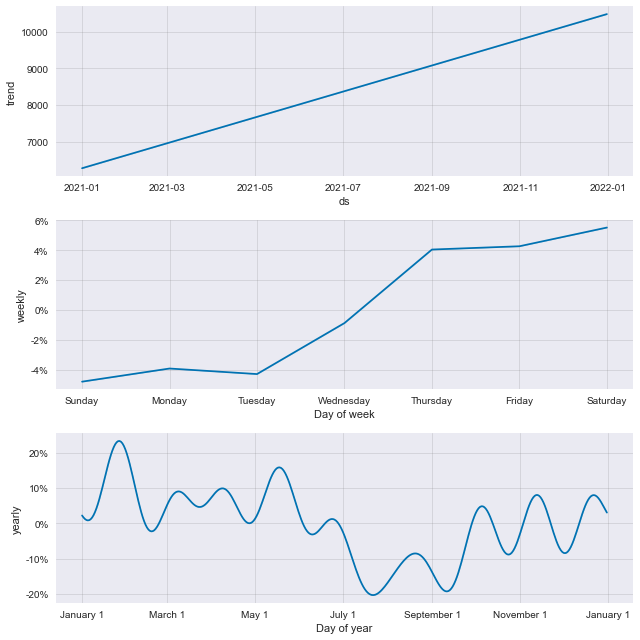

In [117]:
model_3.plot_components(pred_3)

---
## Модель 4
### Prophet (без регрессоров, с учетом периода сезонности)

In [118]:
d21_train_4 = df21_prof[:273]
d21_test_4 = df21_prof[273:]

In [119]:
model_4 = Prophet()
model_4.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

In [120]:
model_4.fit(d21_train_4)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [121]:
pred_4 = model_4.make_future_dataframe(periods=92)

In [122]:
pred_4 = model_4.predict(pred_4)
print(model_4.seasonalities)

OrderedDict([('custom_monthly', {'period': 30.5, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])


In [123]:
pred_4_interval = pred_4[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [124]:
pred_4_plt = pred_4[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

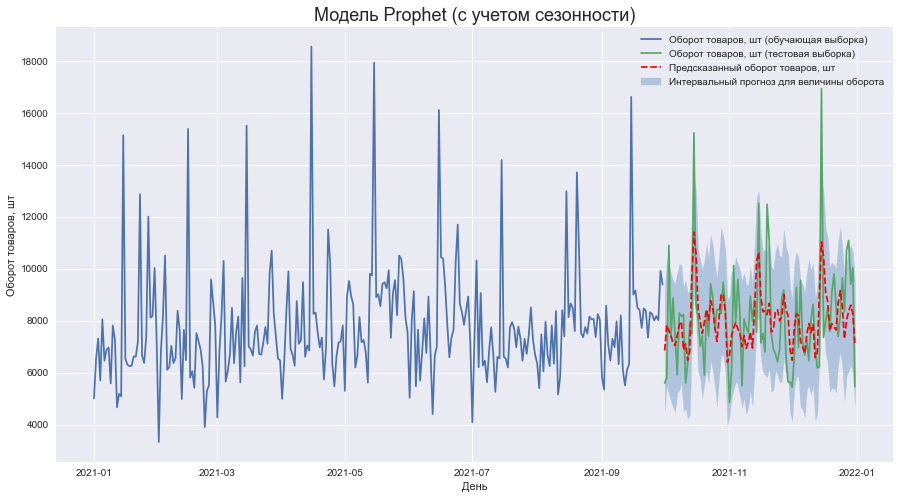

In [125]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_4['ds'], d21_train_4['y']);
plt.plot(d21_test_4['ds'], d21_test_4['y']);
plt.plot(pred_4_plt['ds'], pred_4_plt['y'], 'r--');
plt.fill_between(pred_4_interval['ds'], pred_4_interval['yhat_lower'], pred_4_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с учетом сезонности)', size=18);

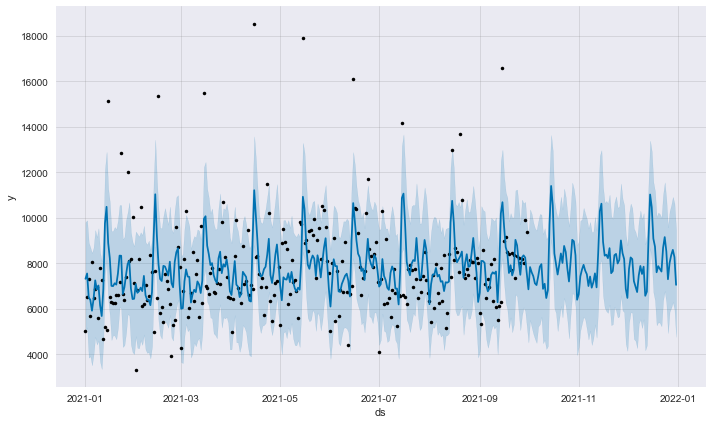

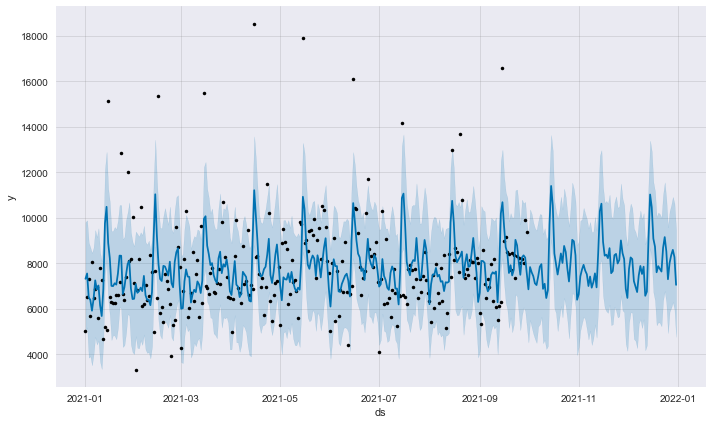

In [126]:
model_4.plot(pred_4, uncertainty=True)

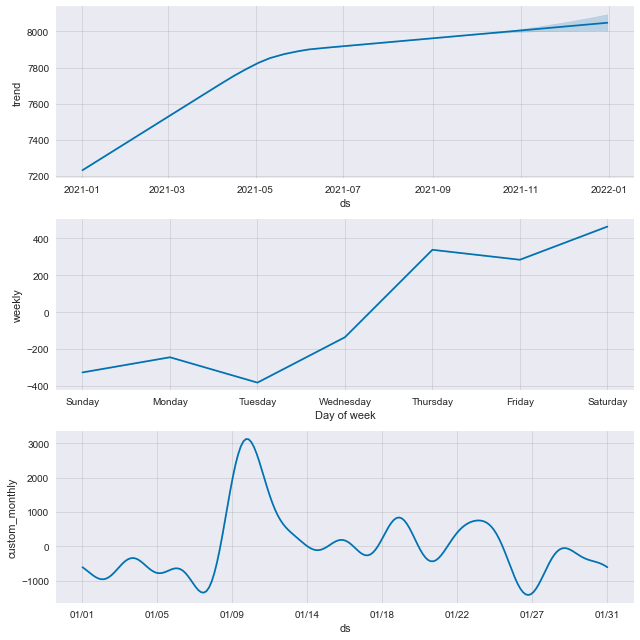

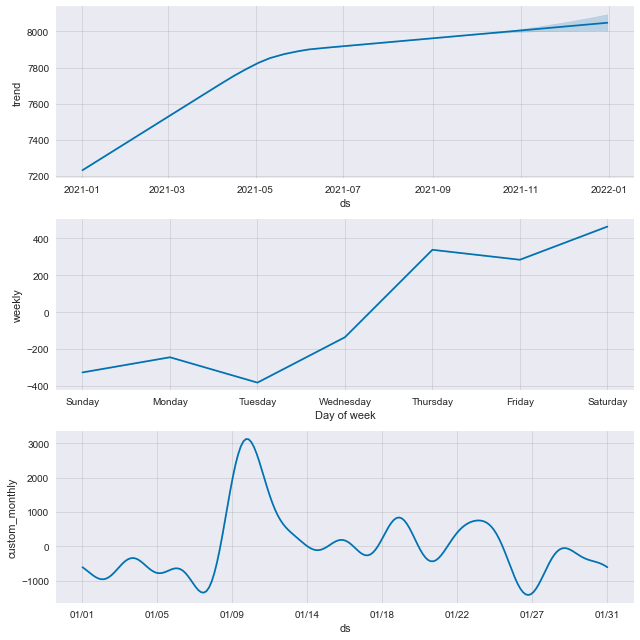

In [127]:
model_4.plot_components(pred_4, uncertainty=True)

---
## Модель 5
### Prophet (с учетом регрессоров)

In [128]:
df21_prof['reg1'] = 0

In [129]:
df21_prof

ds      y  reg1
0   2021-01-01   5011     0
1   2021-01-02   6538     0
2   2021-01-03   7312     0
3   2021-01-04   5699     0
4   2021-01-05   8054     0
..         ...    ...   ...
360 2021-12-27  10699     0
361 2021-12-28  11086     0
362 2021-12-29   9400     0
363 2021-12-30  10043     0
364 2021-12-31   5464     0

[365 rows x 3 columns]

In [130]:
for i in range(df21_prof.shape[0]):
    if df21_prof['ds'][i].day == 15:
        df21_prof['reg1'][i] = 1
    else:
        df21_prof['reg1'][i] = 0

<ipython-input-130-c19698e5818c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-130-c19698e5818c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
d21_train_5 = df21_prof[:273]
d21_test_5 = df21_prof[273:]

In [132]:
model_5 = Prophet()
model_5.add_regressor('reg1')

In [133]:
model_5.fit(d21_train_5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [134]:
pred_5 = model_5.make_future_dataframe(periods=92)

In [135]:
pred_5['reg1'] = df21_prof['reg1']

In [136]:
pred_5 = model_5.predict(pred_5)

In [137]:
pred_5_interval = pred_5[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [138]:
pred_5_plt = pred_5[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

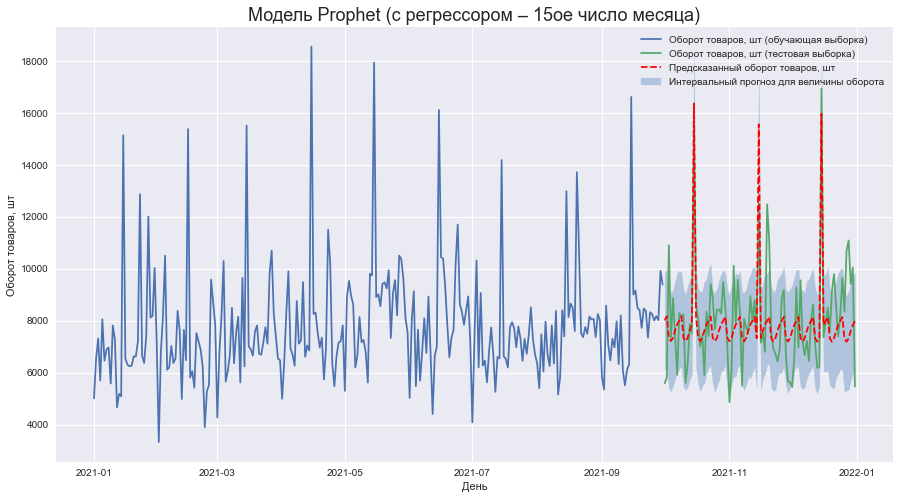

In [139]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_5['ds'], d21_train_5['y']);
plt.plot(d21_test_5['ds'], d21_test_5['y']);
plt.plot(pred_5_plt['ds'], pred_5_plt['y'], 'r--');
plt.fill_between(pred_5_interval['ds'], pred_5_interval['yhat_lower'], pred_5_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с регрессором – 15ое число месяца)', size=18);

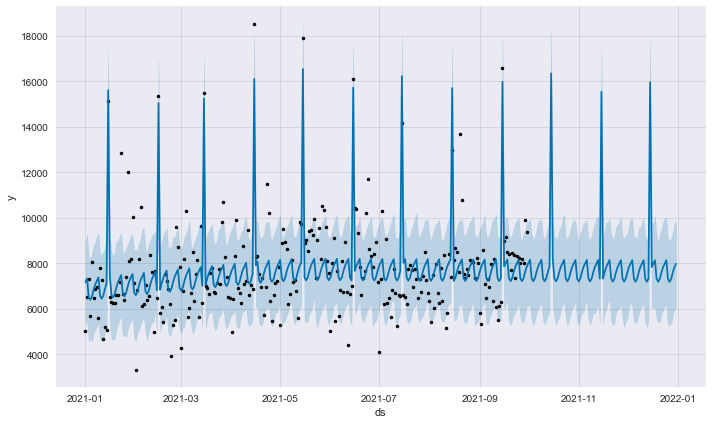

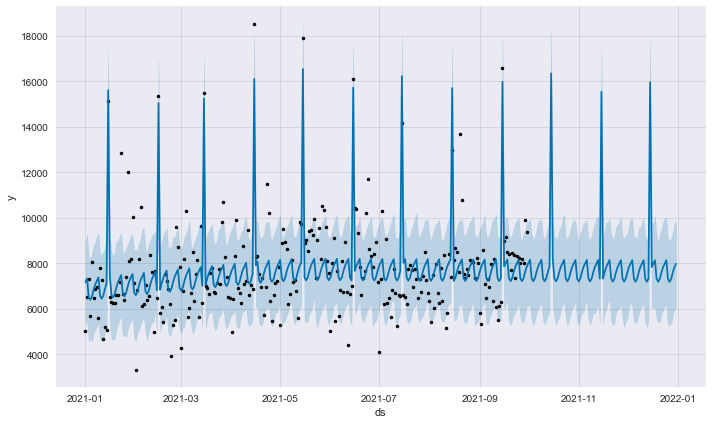

In [140]:
model_5.plot(pred_5, uncertainty=True)

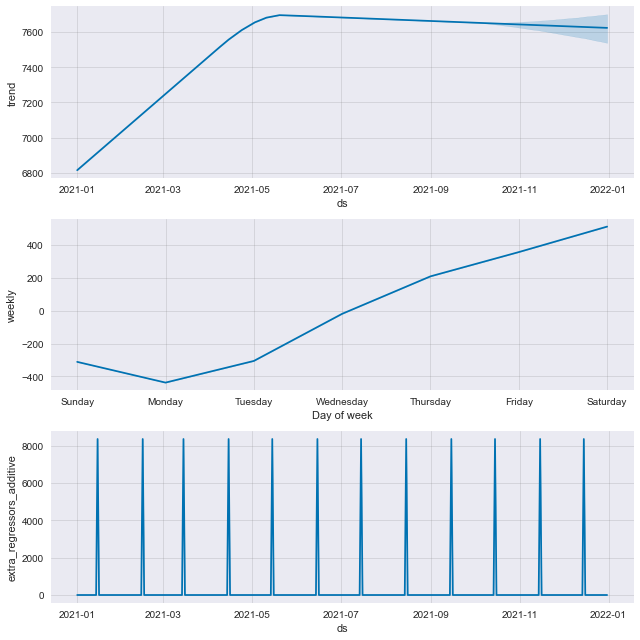

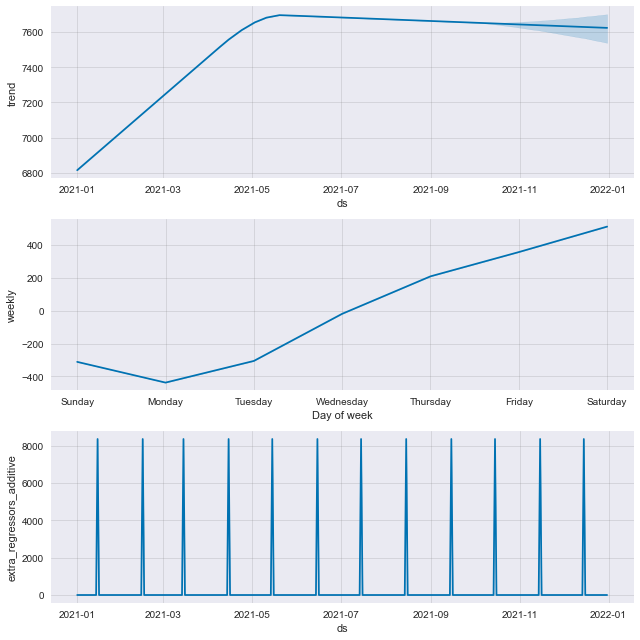

In [141]:
model_5.plot_components(pred_5, uncertainty=True)

---
## Модель 6
### Prophet (с учетом сезонности и регрессора – 15ое число месяца)

In [142]:
d21_train_6 = df21_prof[:273]
d21_test_6 = df21_prof[273:]

In [143]:
model_6 = Prophet(n_changepoints=0)
model_6.add_regressor('reg1')
model_6.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

In [144]:
model_6.fit(d21_train_6)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [156]:
model_6.params

{'k': array([[0.03725249]]),
 'm': array([[0.38389422]]),
 'delta': array([[0.]]),
 'sigma_obs': array([[0.07492035]]),
 'beta': array([[ 0.00673229, -0.02695629, -0.00350861,  0.00212578, -0.01040332,
         -0.00214836,  0.0035994 ,  0.00057146,  0.0044007 ,  0.01513596,
         -0.01435552, -0.00653849,  0.00785337, -0.00668729, -0.00926366,
         -0.00066386, -0.00429228,  0.00813211,  0.00164634,  0.00200073,
          0.01750643,  0.01533997, -0.00265881, -0.00861991, -0.00527183,
          0.00311364,  0.47147252]]),
 'trend': array([[0.38389422, 0.38403118, 0.38416814, 0.3843051 , 0.38444206,
         0.38457901, 0.38471597, 0.38485293, 0.38498989, 0.38512684,
         0.3852638 , 0.38540076, 0.38553772, 0.38567467, 0.38581163,
         0.38594859, 0.38608555, 0.3862225 , 0.38635946, 0.38649642,
         0.38663338, 0.38677034, 0.38690729, 0.38704425, 0.38718121,
         0.38731817, 0.38745512, 0.38759208, 0.38772904, 0.387866  ,
         0.38800295, 0.38813991, 0.388276

In [145]:
pred_6 = model_6.make_future_dataframe(periods=92)

In [146]:
pred_6['reg1'] = df21_prof['reg1']

In [147]:
pred_6 = model_6.predict(pred_6)

In [148]:
pred_6_interval = pred_6[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [149]:
pred_6_plt = pred_6[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

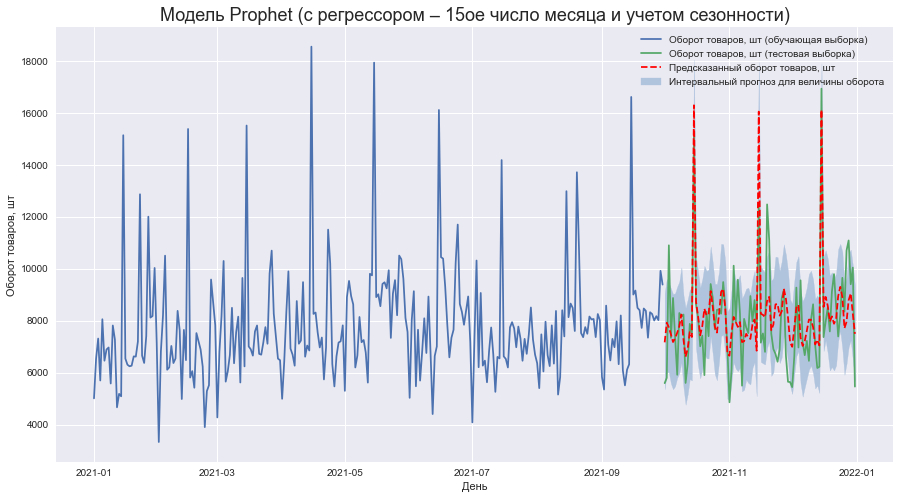

In [150]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_6['ds'], d21_train_6['y']);
plt.plot(d21_test_6['ds'], d21_test_6['y']);
plt.plot(pred_6_plt['ds'], pred_6_plt['y'], 'r--');
plt.fill_between(pred_6_interval['ds'], pred_6_interval['yhat_lower'], pred_6_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с регрессором – 15ое число месяца и учетом сезонности)', size=18);

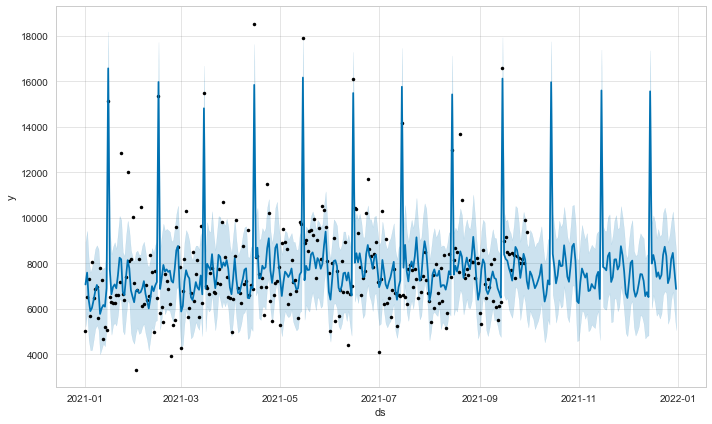

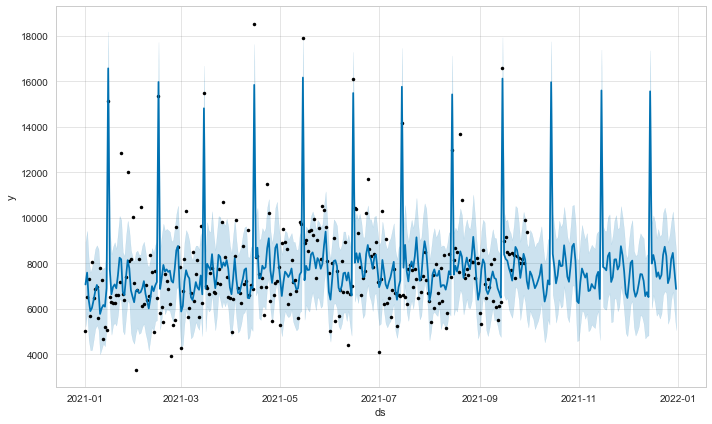

In [97]:
model_6.plot(pred_6, uncertainty=True)

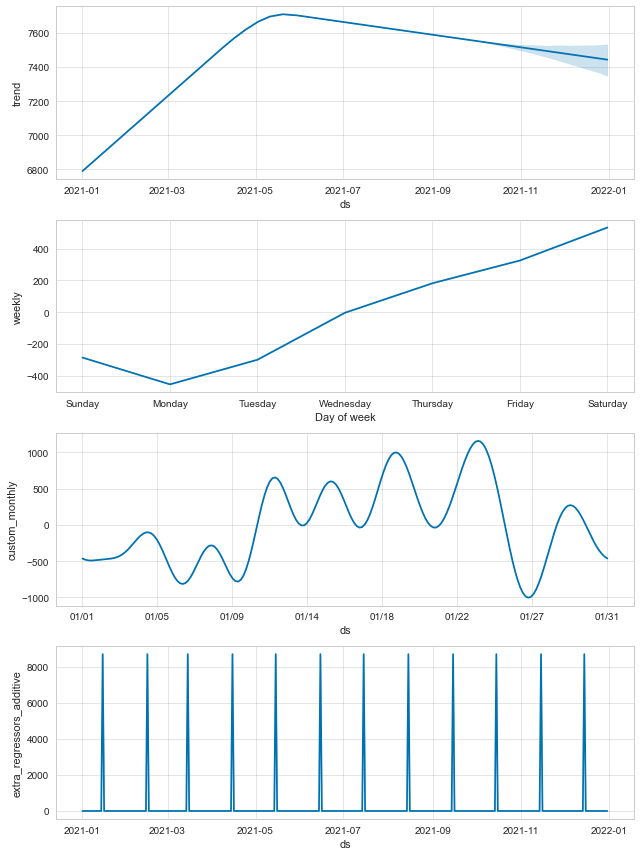

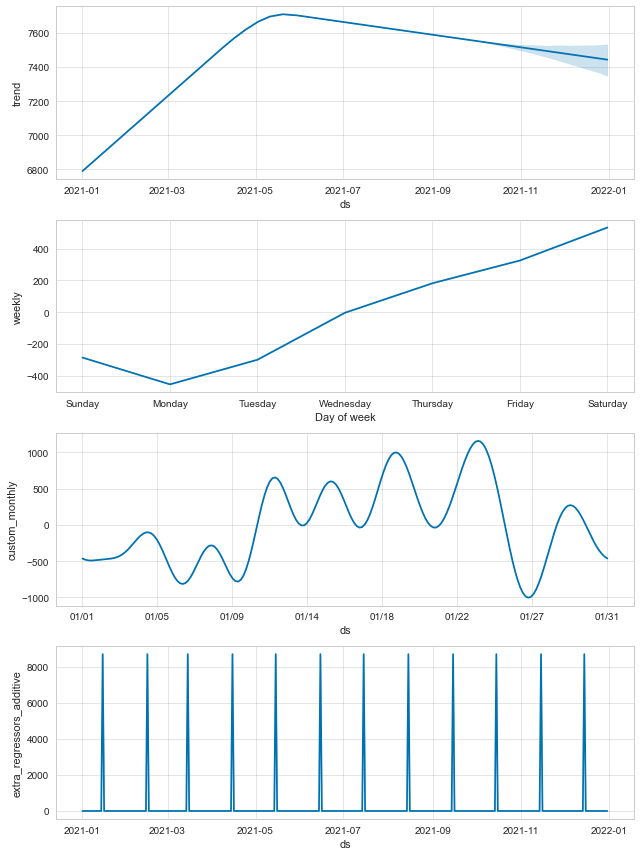

In [98]:
model_6.plot_components(pred_6, uncertainty=True)

---
## Модель 7
### Prophet (с учетом сезонности и регрессоров – 15ое число месяца и 1ое число месяца)

In [99]:
df21_prof['reg2'] = 0

In [100]:
for i in range(df21_prof.shape[0]):
    if df21_prof['ds'][i].day == 1:
        df21_prof['reg2'][i] = 1
    else:
        df21_prof['reg2'][i] = 0

<ipython-input-100-939d3442fd75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df21_prof['reg2'][i] = 1
<ipython-input-100-939d3442fd75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df21_prof['reg2'][i] = 0


In [101]:
d21_train_7 = df21_prof[:273]
d21_test_7 = df21_prof[273:]

In [102]:
model_7 = Prophet()
model_7.add_regressor('reg1')
model_7.add_regressor('reg2')
model_7.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

In [103]:
model_7.fit(d21_train_7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
pred_7 = model_7.make_future_dataframe(periods=92)

In [105]:
pred_7['reg1'] = df21_prof['reg1']
pred_7['reg2'] = df21_prof['reg2']

In [106]:
pred_7 = model_7.predict(pred_7)

In [410]:
pred_7_interval = pred_7[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [107]:
pred_7_plt = pred_7[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

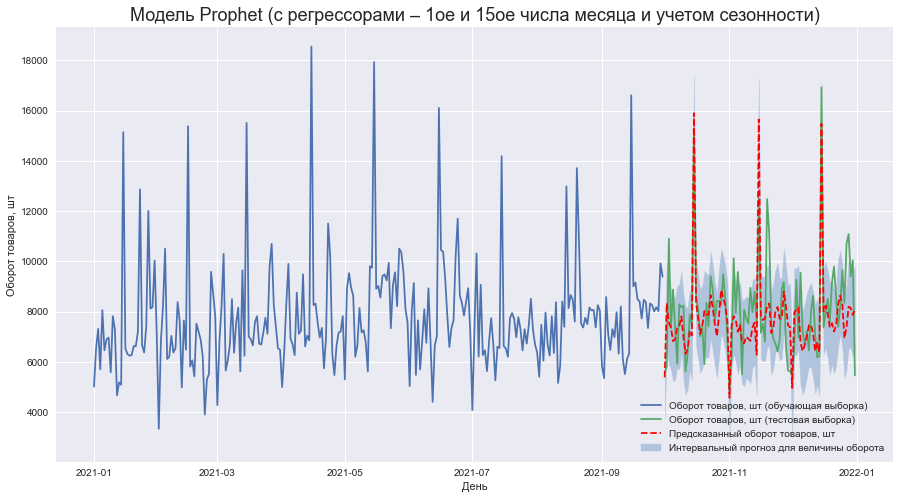

In [411]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_7['ds'], d21_train_7['y']);
plt.plot(d21_test_7['ds'], d21_test_7['y']);
plt.plot(pred_7_plt['ds'], pred_7_plt['y'], 'r--');
plt.fill_between(pred_7_interval['ds'], pred_7_interval['yhat_lower'], pred_7_interval['yhat_upper'], color='lightsteelblue')
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с регрессорами – 1ое и 15ое числа месяца и учетом сезонности)', size=18);

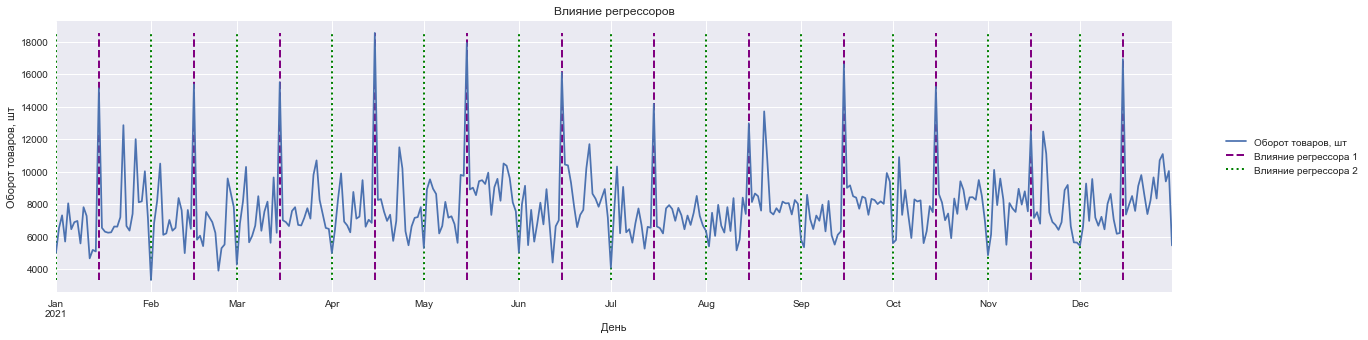

In [412]:
# plotting the regressors
ax = df21_prof.plot(x='ds', y='y', figsize=(20, 5), title='Влияние регрессоров')
ticks, _ = plt.xticks()
y_min = df21_prof.y.min()
y_max = df21_prof.y.max()

plt.vlines(x=list(df21_prof[df21_prof['reg1'] == 1]['ds'].values), ymin=y_min, ymax=y_max, colors='purple', ls='--', lw=2, label='regr1')
plt.vlines(x=list(df21_prof[df21_prof['reg2'] == 1]['ds'].values), ymin=y_min, ymax=y_max, colors='green', ls=':', lw=2, label='regr2')
plt.legend(['Оборот товаров, шт', 'Влияние регрессора 1', 'Влияние регрессора 2'], bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.show()

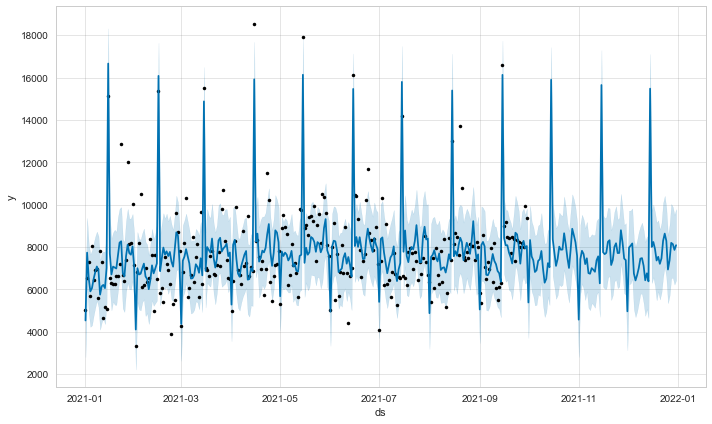

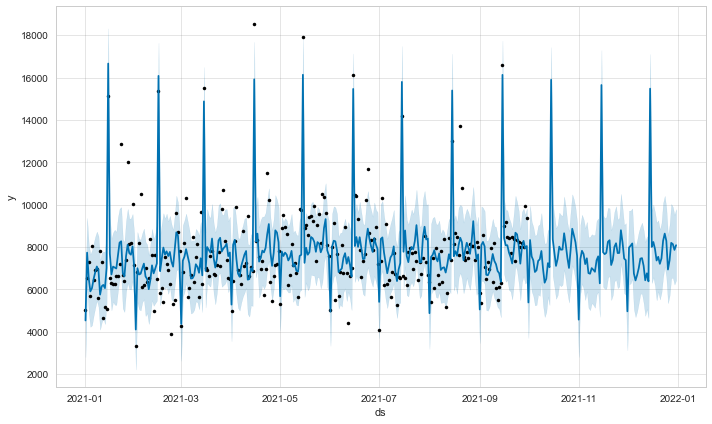

In [110]:
model_7.plot(pred_7, uncertainty=True)

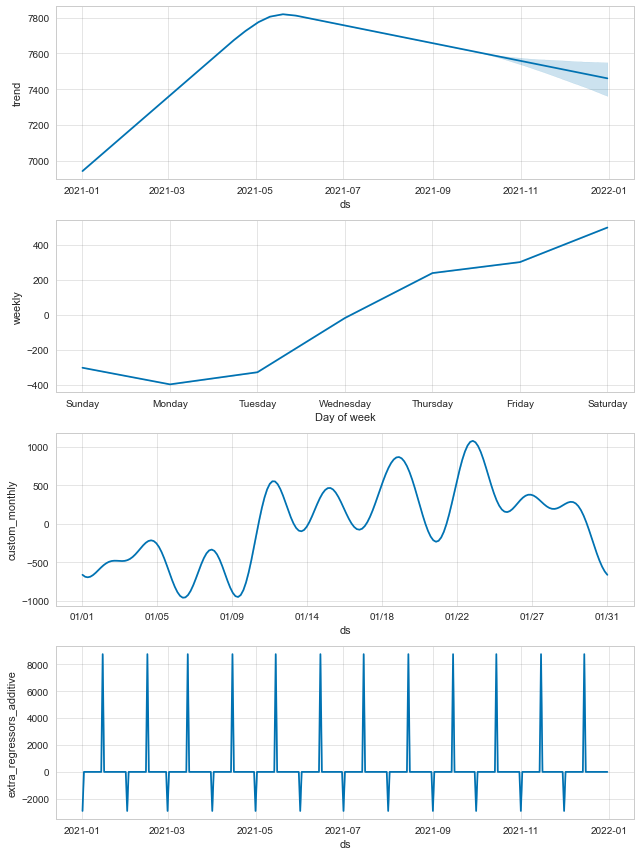

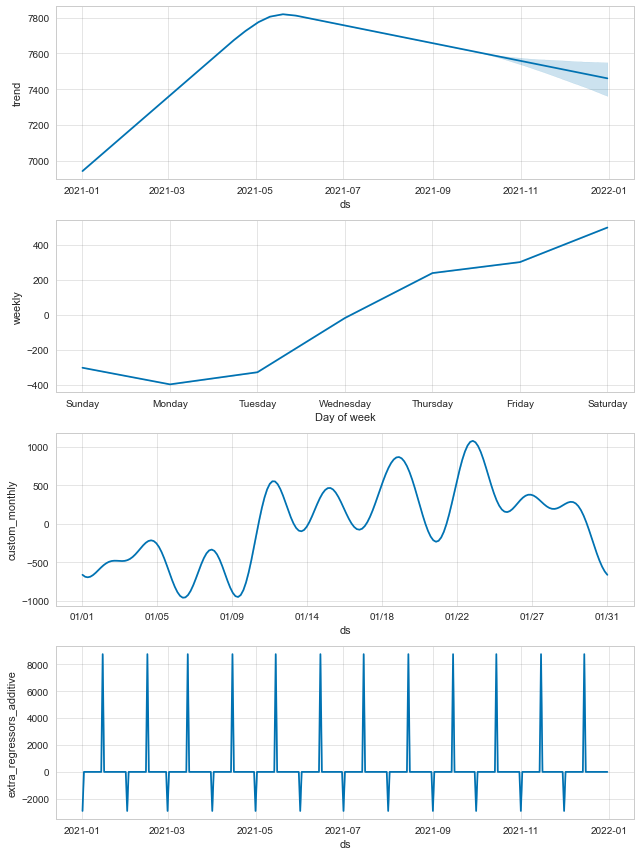

In [111]:
model_7.plot_components(pred_7, uncertainty=True)

---
## Модель 8
### Auto-arima (SARIMA(1,0,0)(0,0,3)[30])

In [448]:
d21_train_8 = df21[:273].set_index('date').rename(columns={'turnoverOfGoods':'y'})
d21_test_8 = df21[273:].set_index('date').rename(columns={'turnoverOfGoods':'y'})

In [486]:
model_8 = auto_arima(d21_train_8, start_p=0, start_q=0, test='adf', max_p=3,
                            max_q=3, m=30, seasonal=True, start_P=0, D=None, 
                            start_Q=0, max_P=3, max_Q=3, 
                            trace=True, error_action='ignore', 
                            supress_warnings=True, stepwise=True, stationary=True) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=4966.736, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=4963.789, Time=0.65 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=4961.939, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=5686.944, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=4964.396, Time=0.01 sec
 ARIMA(0,0,1)(1,0,1)[30] intercept   : AIC=4963.939, Time=1.70 sec
 ARIMA(0,0,1)(0,0,2)[30] intercept   : AIC=4961.676, Time=4.72 sec
 ARIMA(0,0,1)(1,0,2)[30] intercept   : AIC=inf, Time=9.10 sec
 ARIMA(0,0,1)(0,0,3)[30] intercept   : AIC=4960.905, Time=6.27 sec
 ARIMA(0,0,1)(1,0,3)[30] intercept   : AIC=4962.896, Time=8.95 sec
 ARIMA(0,0,0)(0,0,3)[30] intercept   : AIC=4963.289, Time=4.90 sec
 ARIMA(1,0,1)(0,0,3)[30] intercept   : AIC=4962.773, Time=8.44 sec
 ARIMA(0,0,2)(0,0,3)[30] intercept   : AIC=4962.607, Time=6.68 sec
 ARIMA(1,0,0)(0,0,3)[30] intercept   : AIC=4960.738, Time=8.14 sec
 ARIMA(1,0,0)(0,0,2)[30]

In [755]:
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  273
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2, 3], 30)   Log Likelihood               -2474.369
Date:                                    Tue, 05 Apr 2022   AIC                           4960.738
Time:                                            16:45:06   BIC                           4982.395
Sample:                                                 0   HQIC                          4969.432
                                                    - 273                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6747.9530    616.405     10.947      0.000    5539.821    7956.085
ar.L1          0.1296      0.075      1.736      0.083      -0.017       0.276
ma.S.L30       0.1231      0.048      2.566      0.010       0.029       0.217
ma.S.L60      -0.1129      0.100     -1.128      0.259      -0.309       0.083
ma.S.L90       0.1320      0.061      2.165      0.030       0.013       0.252
sigma2      4.505e+06   3.04e+05     14.828      0.000    3.91e+06     5.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               538.58
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             1.91
Prob(H) (two-sided):                  0.03   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [491]:
pred_8 = pd.DataFrame(model_8.predict(n_periods=92), index=d21_test_8.index).rename(columns={0:'y'}).reset_index()

In [492]:
pred_8.head()

date            y
0 2021-10-01  8277.076207
1 2021-10-02  7394.320935
2 2021-10-03  8255.970352
3 2021-10-04  7531.325983
4 2021-10-05  7537.381763

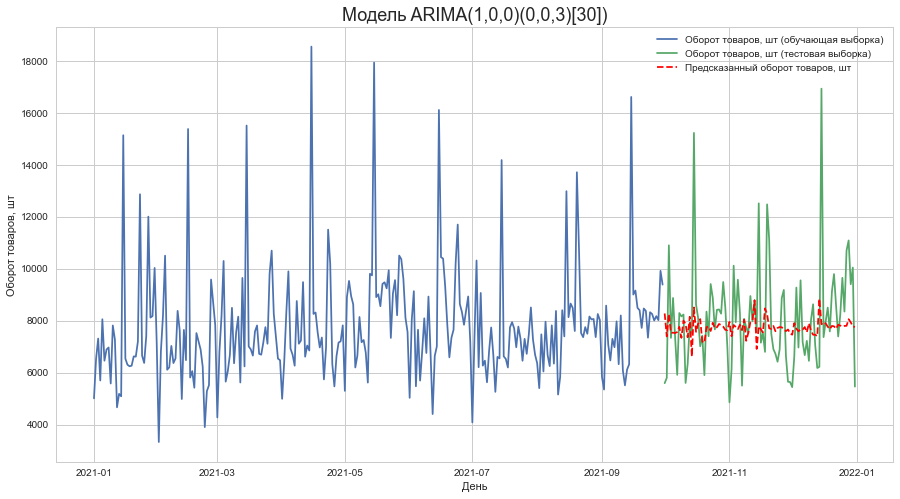

In [497]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_8.reset_index()['date'], d21_train_8['y']);
plt.plot(d21_test_8.reset_index()['date'], d21_test_8['y']);
plt.plot(pred_8['date'], pred_8['y'], 'r--');
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель ARIMA(1,0,0)(0,0,3)[30])', size=18);

---
## Модель 9
### Auto-arima (SARIMA(1,0,0)(0,0,1)[31])

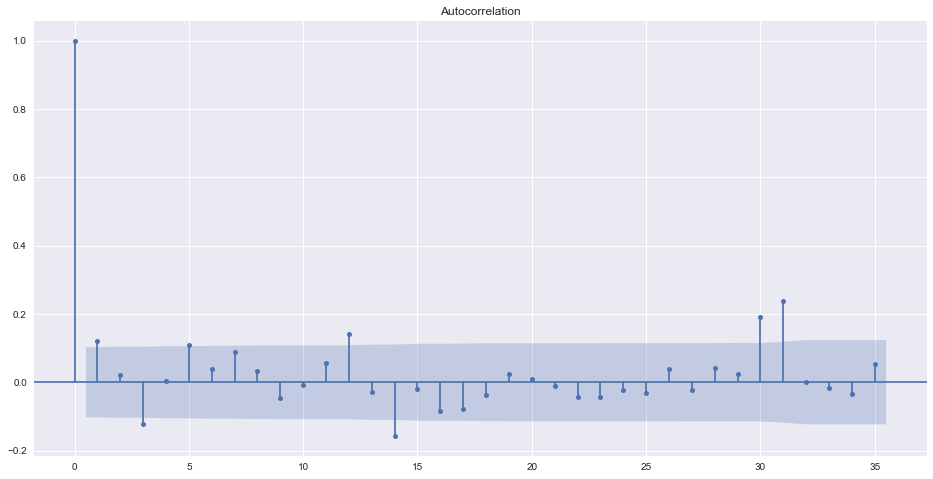

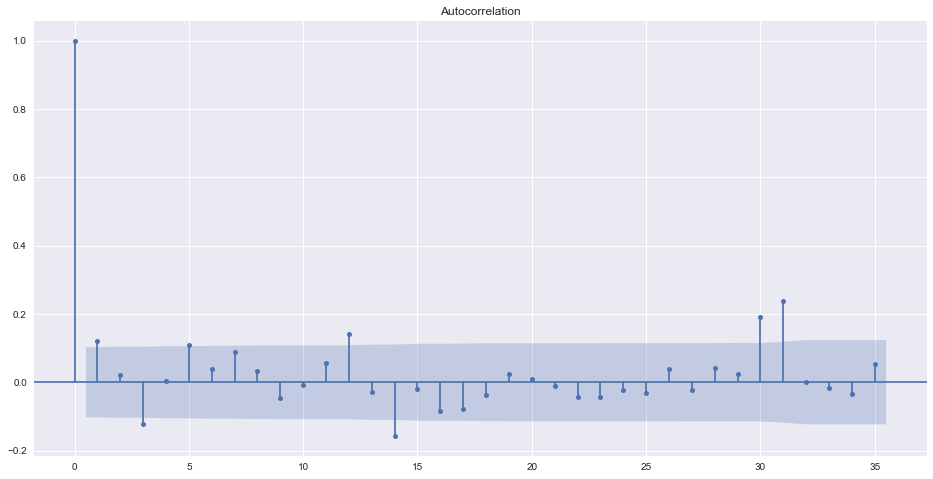

In [762]:
plot_acf(df21['turnoverOfGoods'], lags=35)

In [991]:
d21_train_9 = df21.set_index('date')[:273]
d21_test_9 = df21.set_index('date')[273:]

In [992]:
model_9 = auto_arima(d21, seasonal=True, m=31, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model_9

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[31] intercept   : AIC=inf, Time=4.55 sec
 ARIMA(0,0,0)(0,0,0)[31] intercept   : AIC=6623.734, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[31] intercept   : AIC=6610.989, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[31] intercept   : AIC=6601.036, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[31]             : AIC=7608.583, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[31] intercept   : AIC=6620.683, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[31] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,0,1)(0,0,2)[31] intercept   : AIC=inf, Time=8.27 sec
 ARIMA(0,0,1)(1,0,0)[31] intercept   : AIC=6620.865, Time=0.79 sec
 ARIMA(0,0,1)(1,0,2)[31] intercept   : AIC=6604.871, Time=13.73 sec
 ARIMA(0,0,0)(0,0,1)[31] intercept   : AIC=6602.290, Time=0.88 sec
 ARIMA(1,0,1)(0,0,1)[31] intercept   : AIC=6602.919, Time=0.76 sec
 ARIMA(0,0,2)(0,0,1)[31] intercept   : AIC=6602.629, Time=0.60 sec
 ARIMA(1,0,0)(0,0,1)[31] intercept   : AIC=6600.892, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[31] intercep

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 1, 31),
      suppress_warnings=True)

In [993]:
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  365
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 31)   Log Likelihood               -3296.446
Date:                              Tue, 05 Apr 2022   AIC                           6600.892
Time:                                      19:57:13   BIC                           6616.492
Sample:                                           0   HQIC                          6607.092
                                              - 365                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6895.2539    481.205     14.329      0.000    5952.110    7838.398
ar.L1          0.1191      0.055      2.178      0.029       0.012       0.226
ma.S.L31       0.2613      0.036      7.301      0.000       0.191       0.331
sigma2      4.331e+06   2.41e+05     17.996      0.000    3.86e+06     4.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               643.63
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.79
Prob(H) (two-sided):                  0.18   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [994]:
model_9 = sm.tsa.statespace.SARIMAX(d21, order=(1, 0, 0), seasonal_order=(0, 0, 1, 31))
model_9 = model_9.fit()
print(model_9.summary().tables[1])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9100      0.020     46.643      0.000       0.872       0.948
ma.S.L31       0.3095      0.041      7.480      0.000       0.228       0.391
sigma2      7.508e+06    3.5e+05     21.453      0.000    6.82e+06    8.19e+06


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


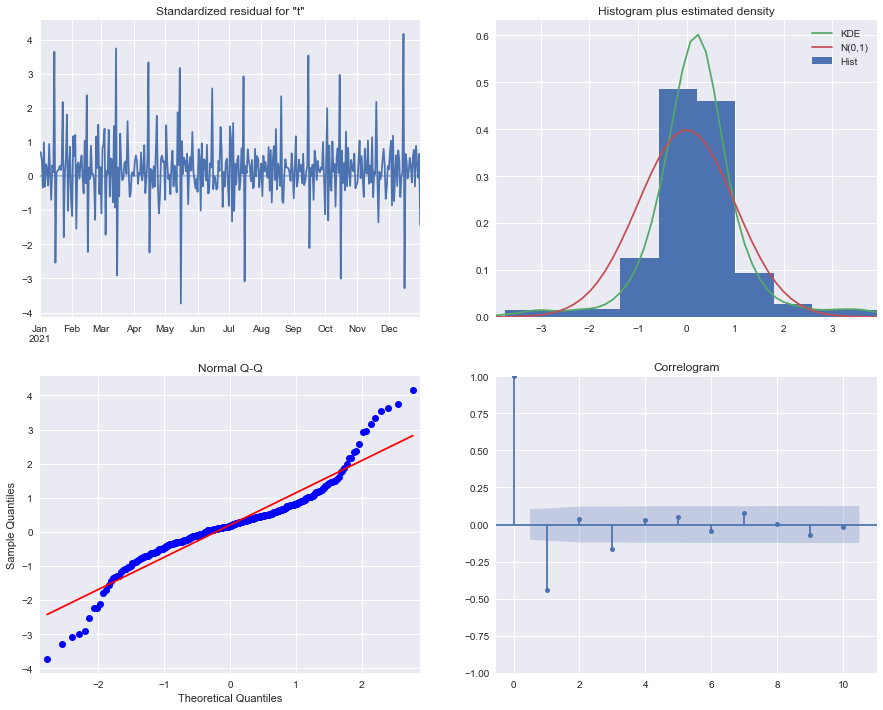

In [995]:
model_9.plot_diagnostics(figsize=(15, 12))
plt.show()

In [996]:
pred_9 = model_9.get_prediction(start=pd.to_datetime('2021-10-01'), end=pd.to_datetime('2021-12-31'), dynamic=False)

In [997]:
pred_9 = pred_9.predicted_mean

In [998]:
pred_9 = pd.DataFrame(pred_9).reset_index().rename(columns={'index':'date', 'predicted_mean':'turnoverOfGoods'})

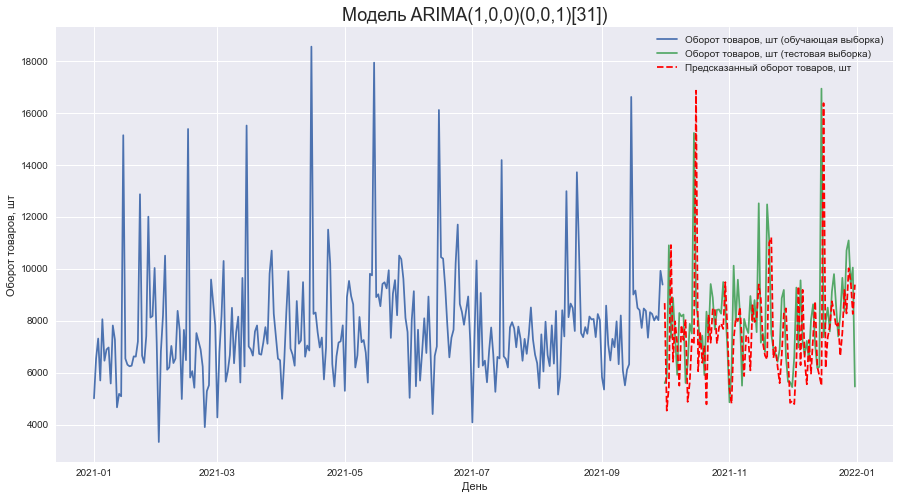

In [1000]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_9.reset_index()['date'], d21_train_9['turnoverOfGoods']);
plt.plot(d21_test_9.reset_index()['date'], d21_test_9['turnoverOfGoods']);
plt.plot(pred_9['date'], pred_9['turnoverOfGoods'], 'r--');
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель ARIMA(1,0,0)(0,0,1)[31])', size=18);

---
## Модель 10
### Auto-arima (SARIMA(3,0,4)(1,0,1)[31], trend='t' (линейный))

In [1003]:
d21_train_10 = df21.set_index('date')[:273]
d21_test_10 = df21.set_index('date')[273:]

In [778]:
model_10 = auto_arima(d21_train_10, seasonal=True, m=31, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True, trend='t')
model_10

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[31] intercept   : AIC=inf, Time=4.31 sec
 ARIMA(0,0,0)(0,0,0)[31] intercept   : AIC=5342.620, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[31] intercept   : AIC=5066.523, Time=0.84 sec
 ARIMA(0,0,1)(0,0,1)[31] intercept   : AIC=5143.002, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[31]             : AIC=5342.620, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[31] intercept   : AIC=5089.486, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[31] intercept   : AIC=5062.974, Time=9.43 sec
 ARIMA(1,0,0)(2,0,1)[31] intercept   : AIC=inf, Time=13.46 sec
 ARIMA(1,0,0)(1,0,1)[31] intercept   : AIC=5071.490, Time=2.02 sec
 ARIMA(0,0,0)(2,0,0)[31] intercept   : AIC=inf, Time=8.16 sec
 ARIMA(2,0,0)(2,0,0)[31] intercept   : AIC=5031.266, Time=8.52 sec
 ARIMA(2,0,0)(1,0,0)[31] intercept   : AIC=5029.539, Time=1.53 sec
 ARIMA(2,0,0)(0,0,0)[31] intercept   : AIC=5049.669, Time=0.04 sec
 ARIMA(2,0,0)(1,0,1)[31] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(2,0,0)(0,0,1)[31] intercept   :

ARIMA(order=(3, 0, 4), scoring_args={}, seasonal_order=(1, 0, 0, 31),
      suppress_warnings=True, trend='t', with_intercept=False)

In [1004]:
model_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  273
Model:             SARIMAX(3, 0, 4)x(1, 0, [], 31)   Log Likelihood               -2465.910
Date:                             Tue, 05 Apr 2022   AIC                           4951.821
Time:                                     20:01:23   BIC                           4987.916
Sample:                                          0   HQIC                          4966.310
                                             - 273                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.1561      0.283      0.552      0.581      -0.398       0.710
ar.L1          0.6650      0.057     11.760      0.000       0.554       0.776
ar.L2         -0.5812      0.064     -9.148      0.000      -0.706      -0.457
ar.L3          0.9124      0.051     17.985      0.000       0.813       1.012
ma.L1         -0.5206      0.094     -5.556      0.000      -0.704      -0.337
ma.L2          0.5674      0.061      9.263      0.000       0.447       0.687
ma.L3         -0.9422      0.051    -18.524      0.000      -1.042      -0.843
ma.L4          0.0380      0.082      0.463      0.644      -0.123       0.199
ar.S.L31       0.3256      0.040      8.076      0.000       0.247       0.405
sigma2      4.476e+06   2.04e-08    2.2e+14      0.000    4.48e+06    4.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               363.27
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             1.55
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+30. Standard errors may be unstable.
"""

In [1009]:
model_10 = sm.tsa.statespace.SARIMAX(d21, order=(3, 0, 4), seasonal_order=(1, 0, 0, 31))
model_10 = model_10.fit()
print(model_10.summary().tables[1])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4957      0.462     -1.072      0.284      -1.402       0.410
ar.L2          0.9799      0.063     15.589      0.000       0.857       1.103
ar.L3          0.5157      0.465      1.110      0.267      -0.395       1.426
ma.L1          0.6091      0.464      1.312      0.189      -0.301       1.519
ma.L2         -0.8175      0.089     -9.229      0.000      -0.991      -0.644
ma.L3         -0.6124      0.457     -1.340      0.180      -1.508       0.283
ma.L4         -0.1529      0.066     -2.305      0.021      -0.283      -0.023
ar.S.L31       0.2560      0.034      7.424      0.000       0.188       0.324
sigma2      4.422e+06   4.27e-07   1.03e+13      0.000    4.42e+06    4.42e+06


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


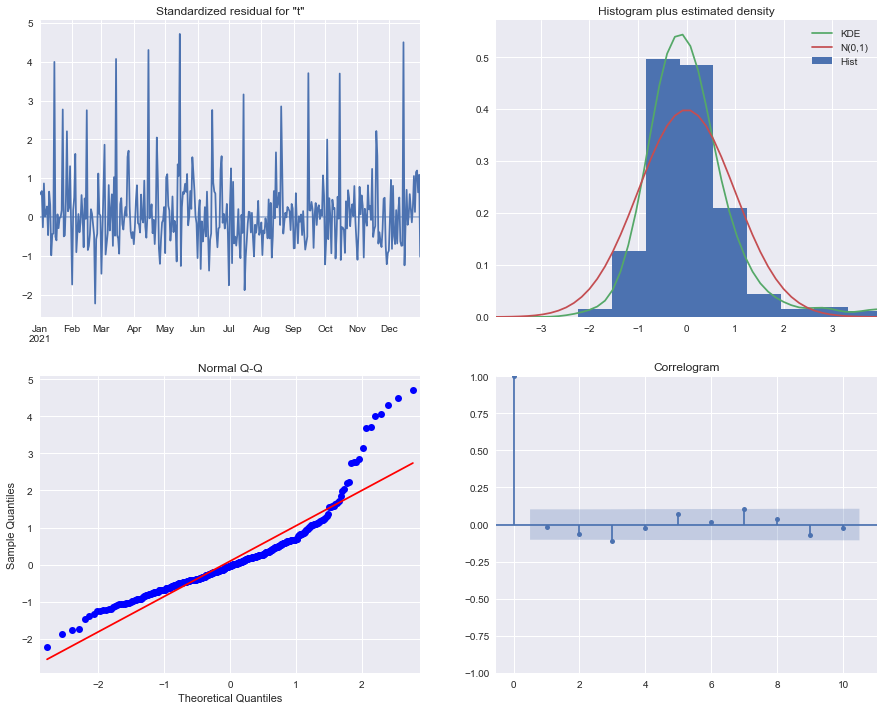

In [1010]:
model_10.plot_diagnostics(figsize=(15, 12))
plt.show()

In [1015]:
pred_10 = pd.DataFrame(model_10.predict(n_periods=92), index=d21_test_10.index).rename(columns={'predicted_mean':'turnoverOfGoods'}).reset_index()

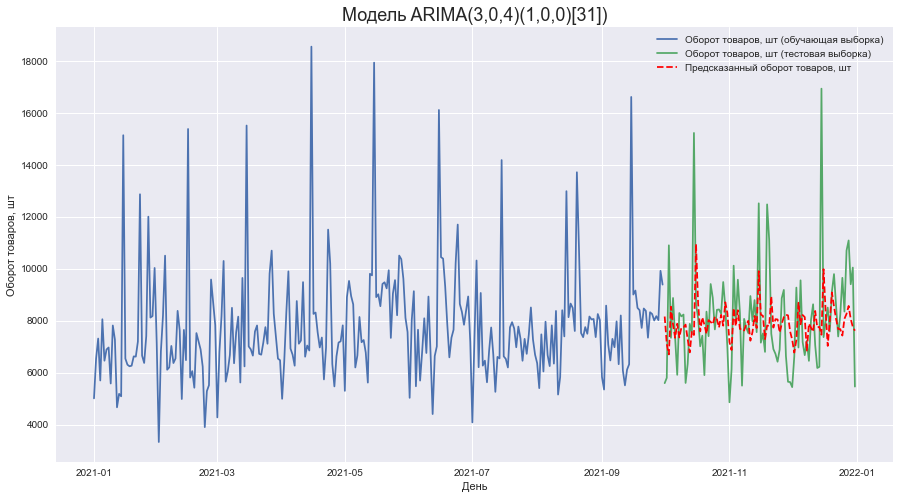

In [1017]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_10.reset_index()['date'], d21_train_10['turnoverOfGoods']);
plt.plot(d21_test_10.reset_index()['date'], d21_test_10['turnoverOfGoods']);
plt.plot(pred_10['date'], pred_10['turnoverOfGoods'], 'r--');
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель ARIMA(3,0,4)(1,0,0)[31])', size=18);

---
## Модель 11
### Prophet (с учетом сезонности и регрессоров – 15ое число месяца и день месяца)

In [141]:
df21_prof['reg3'] = df21_prof['ds'].dt.day

In [116]:
d21_train_11 = df21_prof[['ds', 'y', 'reg1', 'reg3']][:273]
d21_test_11 = df21_prof[['ds', 'y', 'reg1', 'reg3']][273:]

In [118]:
model_11 = Prophet()
model_11.add_regressor('reg1')
model_11.add_regressor('reg3')
model_11.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

In [119]:
model_11.fit(d21_train_11)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [120]:
pred_11 = model_11.make_future_dataframe(periods=92)

In [121]:
pred_11['reg1'] = df21_prof['reg1']
pred_11['reg3'] = df21_prof['reg3']

In [122]:
pred_11 = model_11.predict(pred_11)

In [413]:
pred_11_interval = pred_11[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [123]:
pred_11_plt = pred_11[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

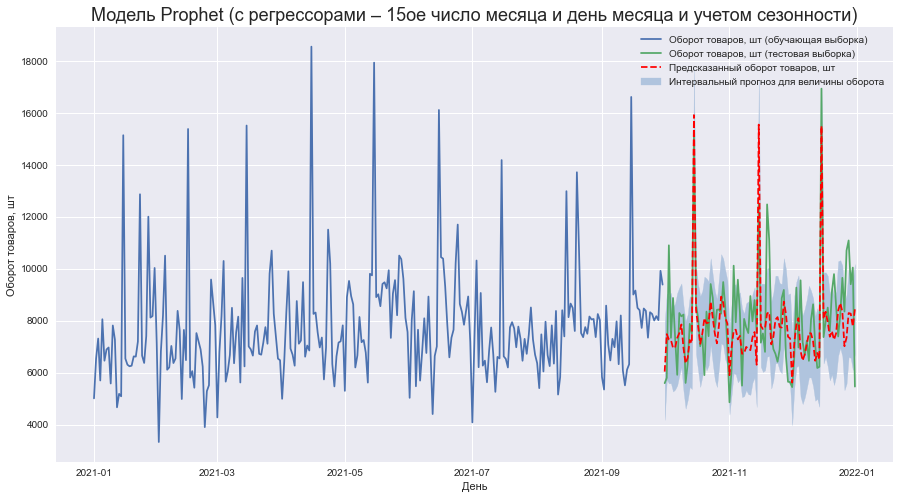

In [414]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_11['ds'], d21_train_11['y']);
plt.plot(d21_test_11['ds'], d21_test_11['y']);
plt.plot(pred_11_plt['ds'], pred_11_plt['y'], 'r--');
plt.fill_between(pred_11_interval['ds'], pred_11_interval['yhat_lower'], pred_11_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с регрессорами – 15ое число месяца и день месяца и учетом сезонности)', size=18);

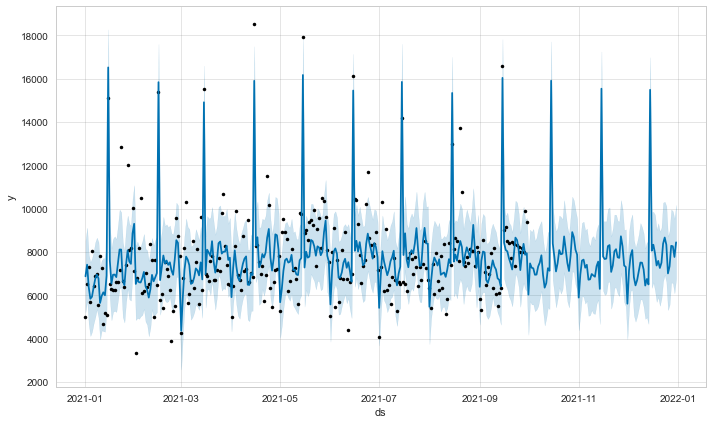

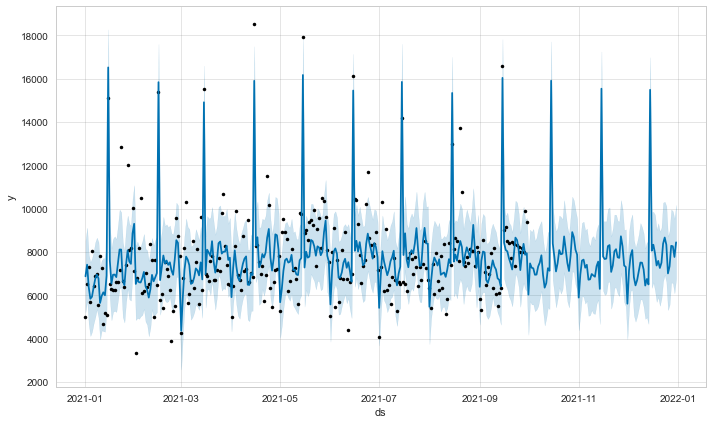

In [125]:
model_11.plot(pred_11, uncertainty=True)

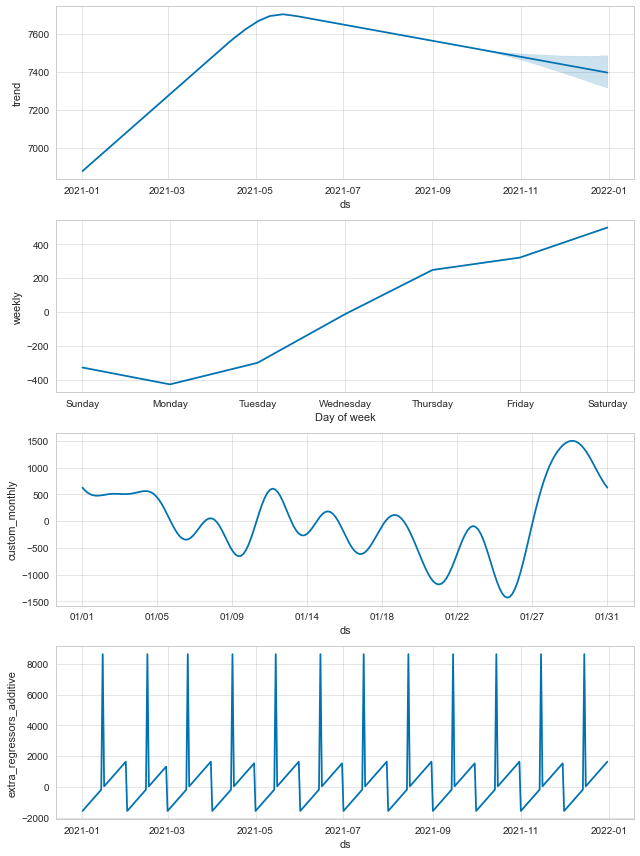

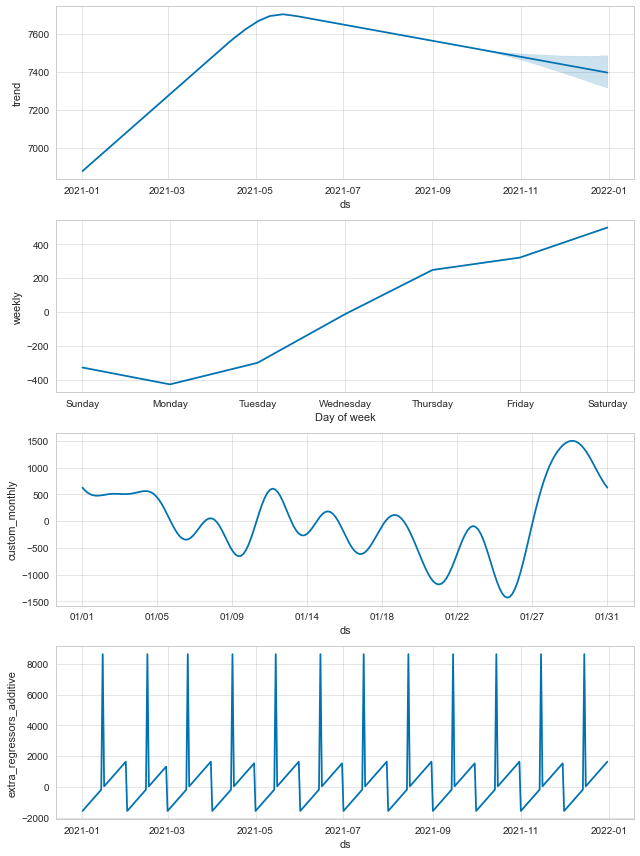

In [126]:
model_11.plot_components(pred_11, uncertainty=True)

---
## Модель 12
### Prophet (с учетом сезонности и регрессоров – 15ое число месяца и день недели)

In [143]:
df21_prof['reg4'] = df21_prof['ds'].dt.weekday

In [144]:
d21_train_12 = df21_prof[['ds', 'y', 'reg1', 'reg4']][:273]
d21_test_12 = df21_prof[['ds', 'y', 'reg1', 'reg4']][273:]

In [145]:
model_12 = Prophet()
model_12.add_regressor('reg1')
model_12.add_regressor('reg4')
model_12.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

In [146]:
model_12.fit(d21_train_12)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [147]:
pred_12 = model_12.make_future_dataframe(periods=92)

In [148]:
pred_12['reg1'] = df21_prof['reg1']
pred_12['reg4'] = df21_prof['reg4']

In [149]:
pred_12 = model_12.predict(pred_12)

In [415]:
pred_12_interval = pred_12[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [150]:
pred_12_plt = pred_12[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

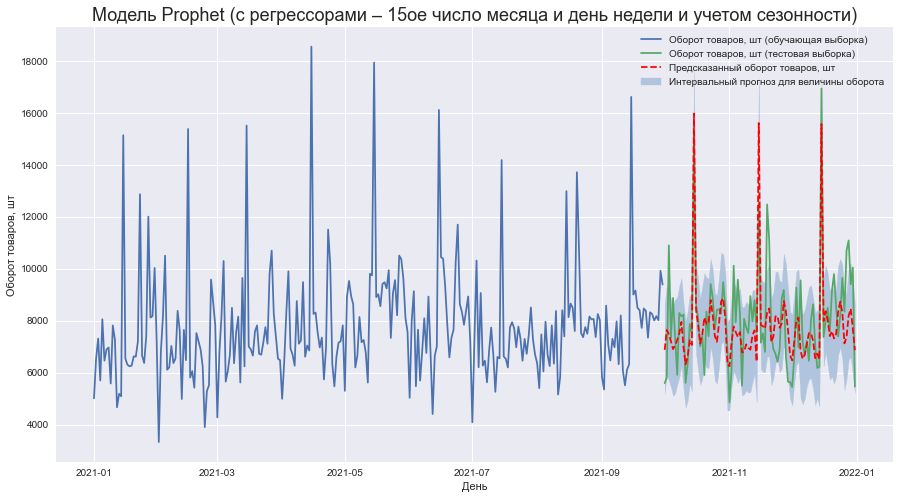

In [416]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_12['ds'], d21_train_12['y']);
plt.plot(d21_test_12['ds'], d21_test_12['y']);
plt.plot(pred_12_plt['ds'], pred_12_plt['y'], 'r--');
plt.fill_between(pred_12_interval['ds'], pred_12_interval['yhat_lower'], pred_12_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с регрессорами – 15ое число месяца и день недели и учетом сезонности)', size=18);

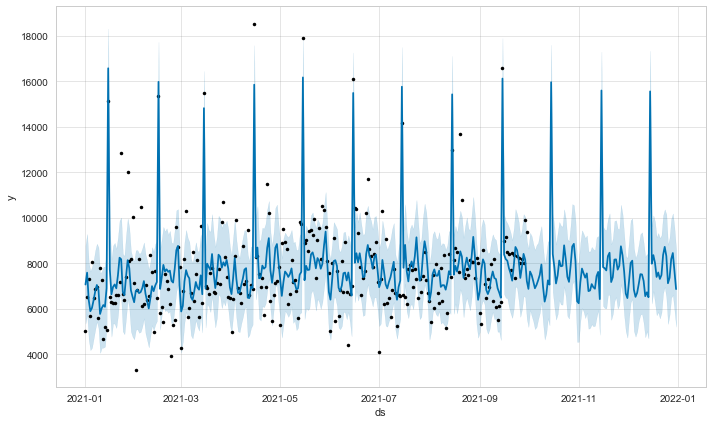

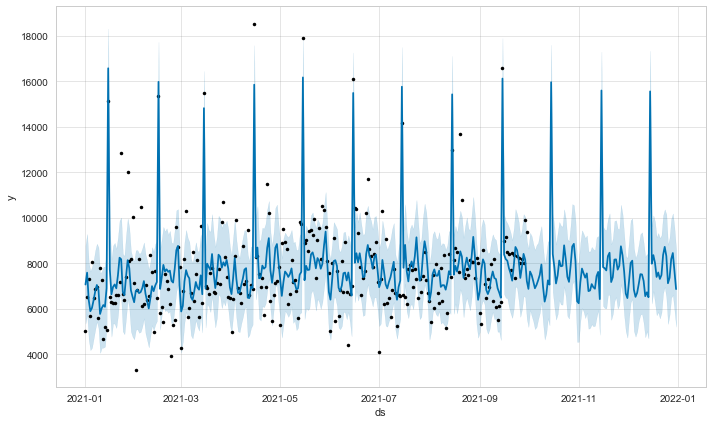

In [152]:
model_12.plot(pred_12, uncertainty=True)

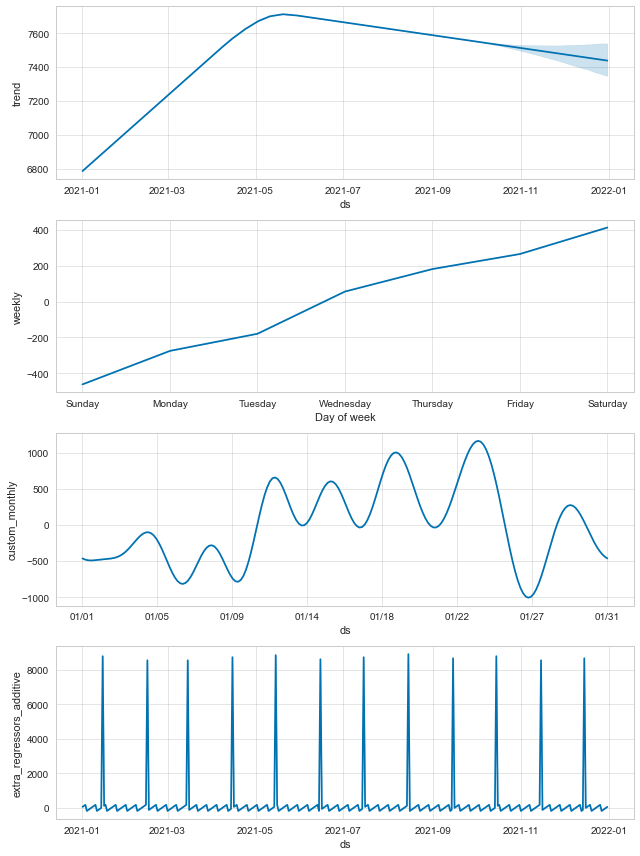

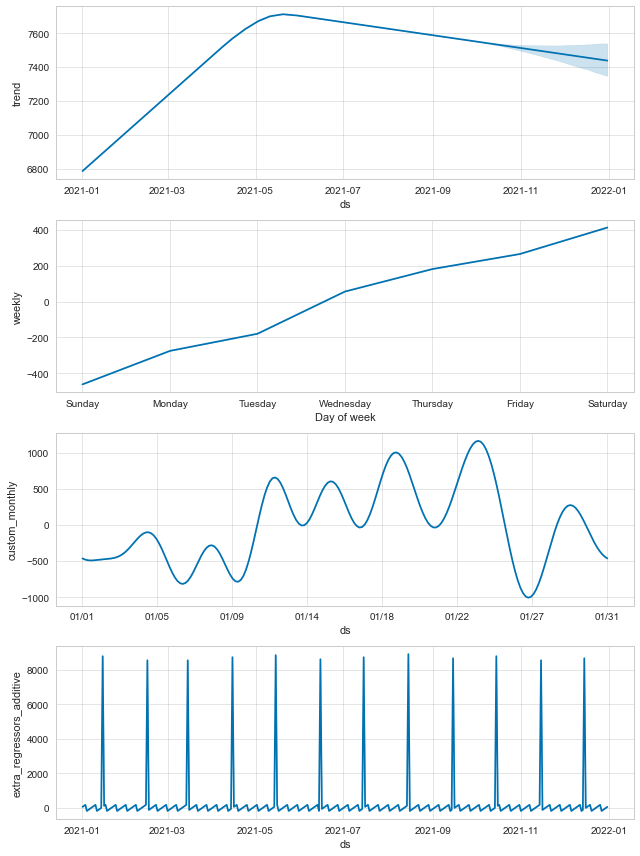

In [153]:
model_12.plot_components(pred_12, uncertainty=True)

---
## Модель 13
### Prophet (с учетом сезонности, регрессора – 15ое число месяца и праздников)

In [419]:
holidays = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2021-01-01', '2021-01-02', '2021-01-03',
                        '2021-01-04', '2021-01-05', '2021-01-06',
                        '2021-01-07', '2021-12-31','2021-02-23',
                        '2021-03-08', '2021-05-01', '2021-05-09',
                        '2021-06-12', '2021-11-04']),
  'lower_window': -5,
  'upper_window': 5,
})

In [420]:
d21_train_13 = df21_prof[:273]
d21_test_13 = df21_prof[273:]

In [421]:
model_13 = Prophet(holidays=holidays, n_changepoints=0)
model_13.add_regressor('reg1')
model_13.add_country_holidays(country_name='RU')
model_13.add_seasonality(name='custom_monthly', period=30.5, fourier_order=15)

In [422]:
model_13.fit(d21_train_13)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [423]:
pred_13 = model_13.make_future_dataframe(periods=92)

In [424]:
pred_13['reg1'] = df21_prof['reg1']

In [425]:
pred_13 = model_13.predict(pred_13)

In [426]:
pred_13_interval = pred_13[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

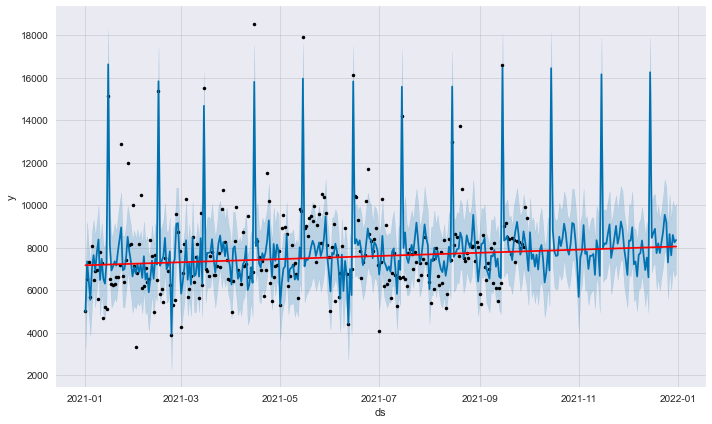

In [427]:
fig = model_13.plot(pred_13)
a = add_changepoints_to_plot(fig.gca(), model_13, pred_13)

In [428]:
pred_13_plt = pred_13[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

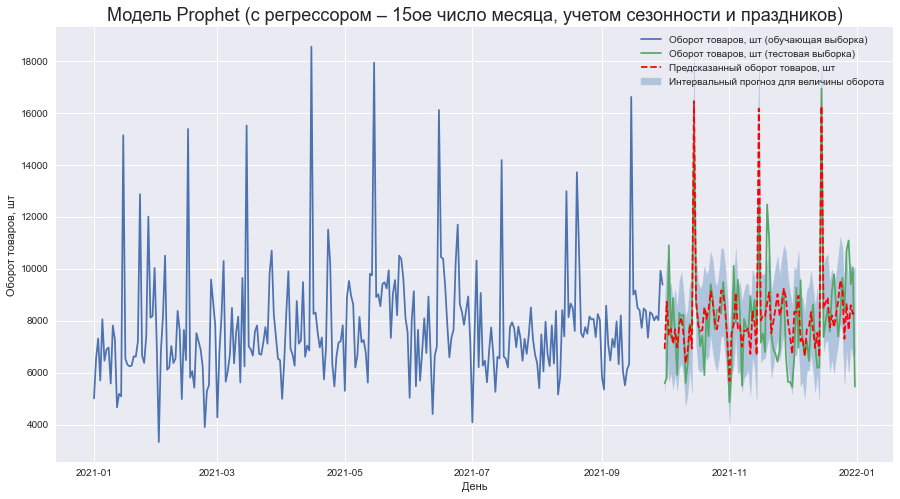

In [429]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_13['ds'], d21_train_13['y']);
plt.plot(d21_test_13['ds'], d21_test_13['y']);
plt.plot(pred_13_plt['ds'], pred_13_plt['y'], 'r--');
plt.fill_between(pred_13_interval['ds'], pred_13_interval['yhat_lower'], pred_13_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (с регрессором – 15ое число месяца, учетом сезонности и праздников)', size=18);

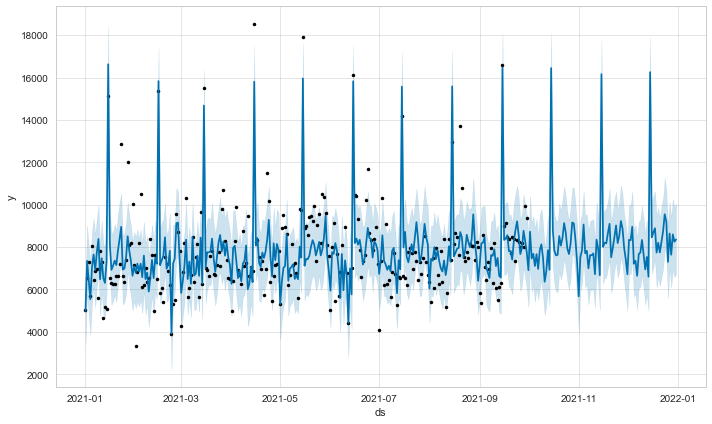

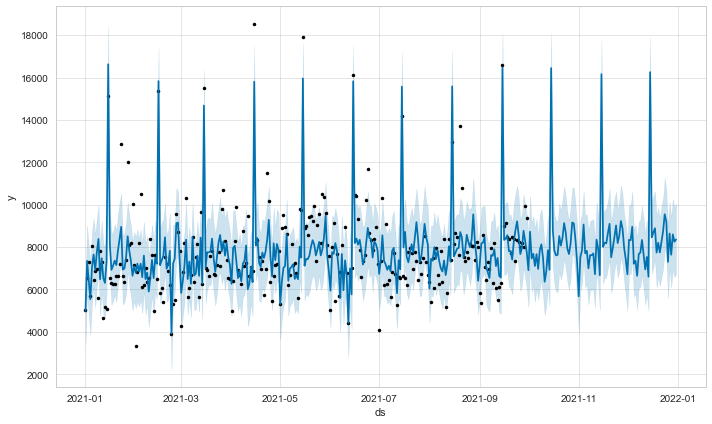

In [331]:
model_13.plot(pred_13, uncertainty=True)

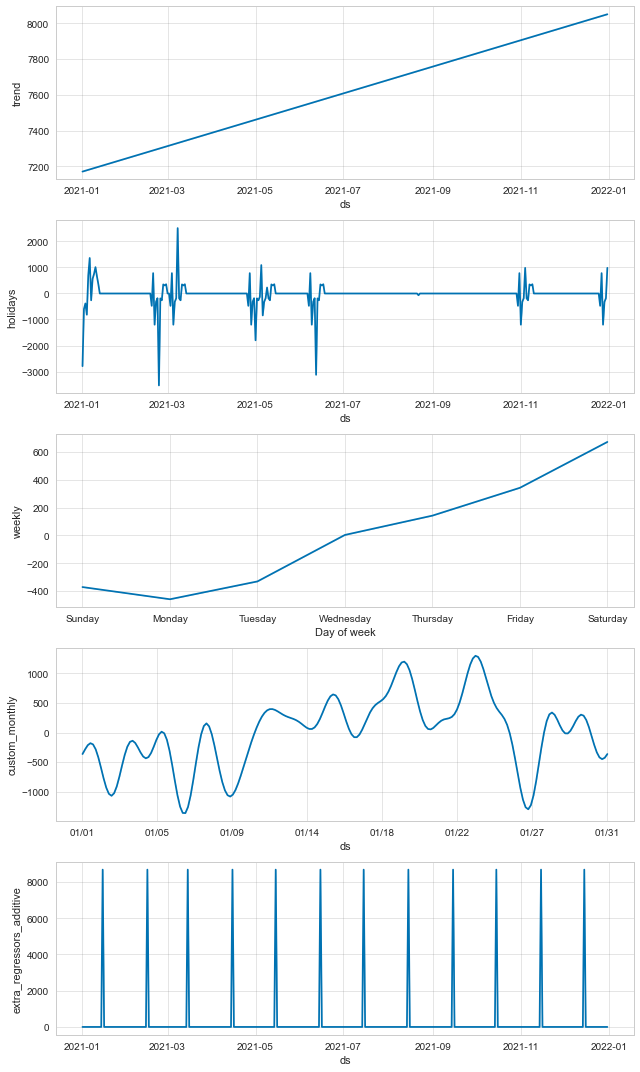

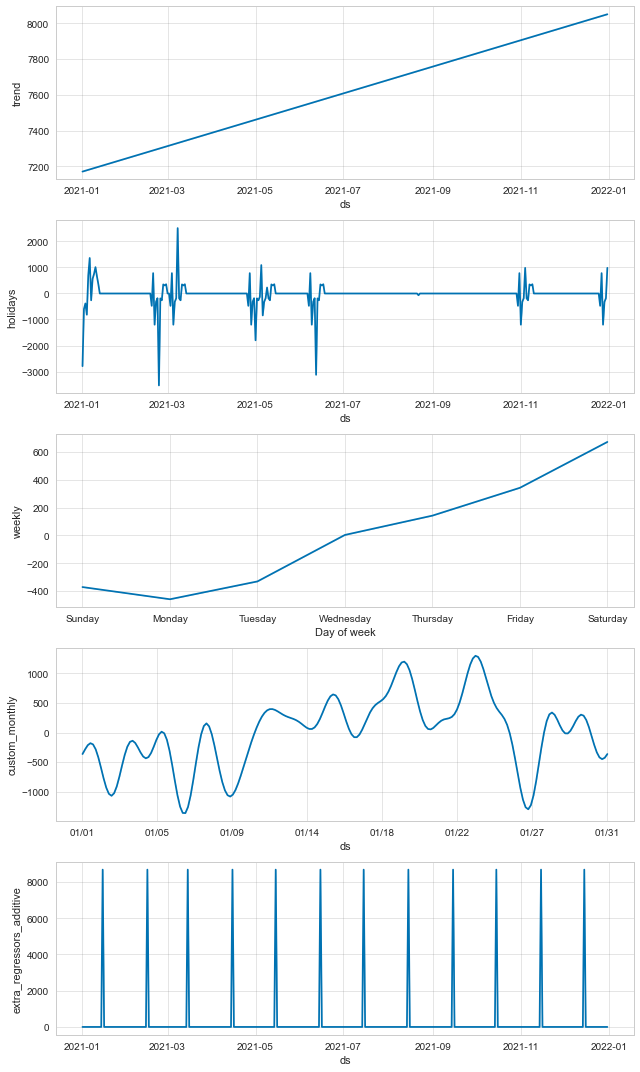

In [332]:
model_13.plot_components(pred_13, uncertainty=True)

---
## Модель 14
### Базовая LSTM

In [336]:
df21_14 = df21_prof['y'].values.astype(float)

In [338]:
d21_train_14 = df21_14[:273]
d21_test_14 = df21_14[273:]

In [343]:
scaler = MinMaxScaler(feature_range=(-1, 1))
d21_train_14_norm = scaler.fit_transform(d21_train_14 .reshape(-1, 1))

In [345]:
d21_train_14_norm = torch.FloatTensor(d21_train_14_norm).view(-1)

In [347]:
train_window = 30

In [348]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [349]:
d21_train_14_inout_seq = create_inout_sequences(d21_train_14_norm, train_window)

In [352]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [353]:
model_14 = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_14.parameters(), lr=0.001)

In [355]:
epochs = 150

for i in range(epochs):
    for seq, labels in d21_train_14_inout_seq:
        optimizer.zero_grad()
        model_14.hidden_cell = (torch.zeros(1, 1, model_14.hidden_layer_size),
                        torch.zeros(1, 1, model_14.hidden_layer_size))

        pred_14 = model_14(seq)

        single_loss = loss_function(pred_14, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.02165432
epoch:  26 loss: 0.02264802
epoch:  51 loss: 0.02993483
epoch:  76 loss: 0.00580032
epoch: 101 loss: 0.04514226
epoch: 126 loss: 0.00980357
epoch: 149 loss: 0.0152356597


In [356]:
fut_pred = 92

test_inputs = d21_train_14_norm[-train_window:].tolist()
print(test_inputs)

[-0.6712473034858704, -0.734630823135376, -0.3101453185081482, -0.507396936416626, -0.5874810814857483, -0.478203684091568, -0.5204155445098877, -0.3897034525871277, -0.6062857508659363, -0.35998421907424927, -0.6379775404930115, -0.7134591341018677, -0.6340324878692627, -0.6066802740097046, 0.7455453872680664, -0.25412583351135254, -0.23374317586421967, -0.32158589363098145, -0.3331579864025116, -0.42297324538230896, -0.3246104419231415, -0.33670851588249207, -0.4724176526069641, -0.343546599149704, -0.3526201546192169, -0.38536393642425537, -0.3634032607078552, -0.3835229277610779, -0.13393385708332062, -0.20362943410873413]


In [357]:
model_14.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model_14.hidden = (torch.zeros(1, 1, model_14.hidden_layer_size),
                        torch.zeros(1, 1, model_14.hidden_layer_size))
        test_inputs.append(model_14(seq).item())

In [361]:
pred_14 = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))

In [376]:
pred_14_plt = pd.DataFrame(index=d21_test_13['ds'].to_list(), data=pred_14).reset_index().rename(columns={'index':'ds', 0:'y'})

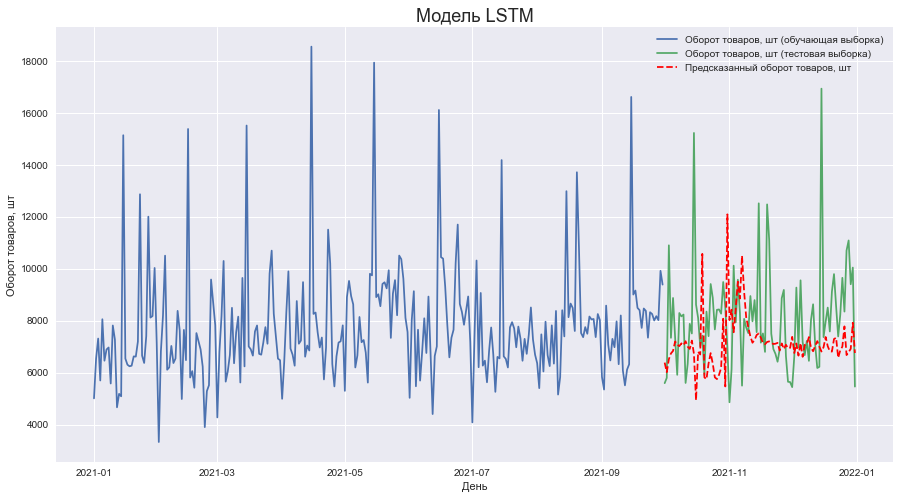

In [377]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_13['ds'], d21_train_13['y']);
plt.plot(d21_test_13['ds'], d21_test_13['y']);
plt.plot(pred_14_plt['ds'], pred_14_plt['y'], 'r--');
plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель LSTM', size=18);

---
## Модель 15
### Prophet (тренд+сезонность)

In [587]:
d21_train_15 = df21_prof[:273][['ds', 'y']]
d21_test_15 = df21_prof[273:][['ds', 'y']]

In [589]:
model_15 = Prophet(yearly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative', growth='linear', seasonality_prior_scale=20)
model_15.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

In [590]:
model_15.fit(d21_train_15)

In [591]:
pred_15 = model_15.make_future_dataframe(periods=92)

In [592]:
pred_15 = model_15.predict(pred_15)
print(model_15.seasonalities)

OrderedDict([('custom_monthly', {'period': 30.5, 'fourier_order': 10, 'prior_scale': 20.0, 'mode': 'multiplicative', 'condition_name': None}), ('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 20.0, 'mode': 'multiplicative', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 20.0, 'mode': 'multiplicative', 'condition_name': None}), ('daily', {'period': 1, 'fourier_order': 4, 'prior_scale': 20.0, 'mode': 'multiplicative', 'condition_name': None})])


In [593]:
pred_15_interval = pred_15[['ds', 'yhat_lower', 'yhat_upper']].loc[273:]

In [594]:
pred_15_plt = pred_15[['ds', 'yhat']].loc[273:].rename(columns={'yhat':'y'})

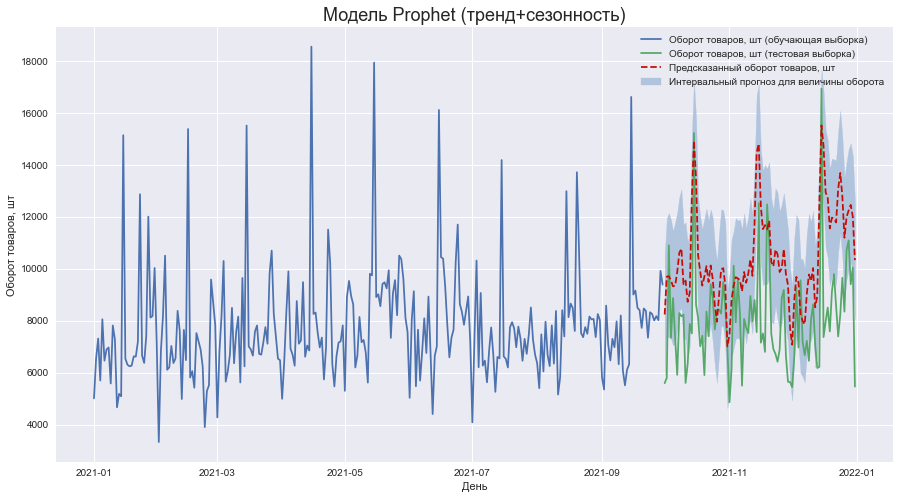

In [595]:
plt.figure(figsize=(15, 8))
plt.plot(d21_train_15['ds'], d21_train_15['y']);
plt.plot(d21_test_15['ds'], d21_test_15['y']);
plt.plot(pred_15_plt['ds'], pred_15_plt['y'], 'r--');
plt.fill_between(pred_15_interval['ds'], pred_15_interval['yhat_lower'], pred_15_interval['yhat_upper'], color='lightsteelblue')

plt.legend(['Оборот товаров, шт (обучающая выборка)', 'Оборот товаров, шт (тестовая выборка)', 'Предсказанный оборот товаров, шт', 'Интервальный прогноз для величины оборота'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель Prophet (тренд+сезонность)', size=18);

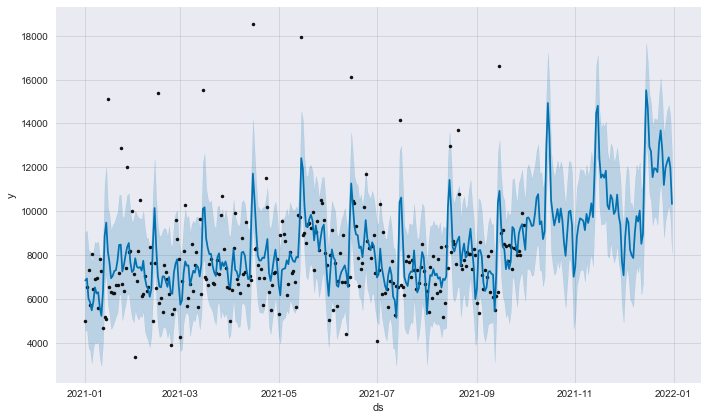

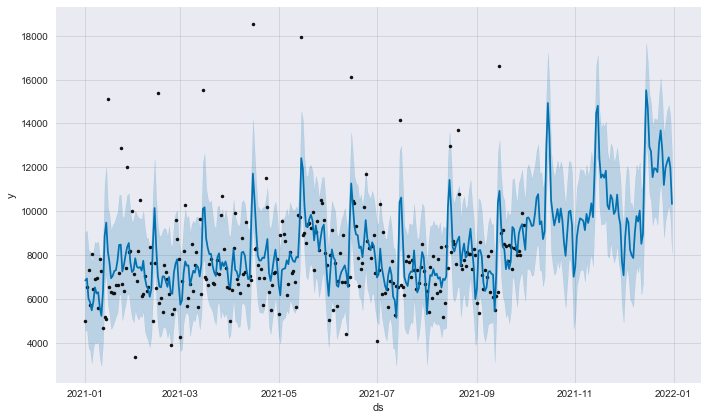

In [596]:
model_15.plot(pred_15, uncertainty=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



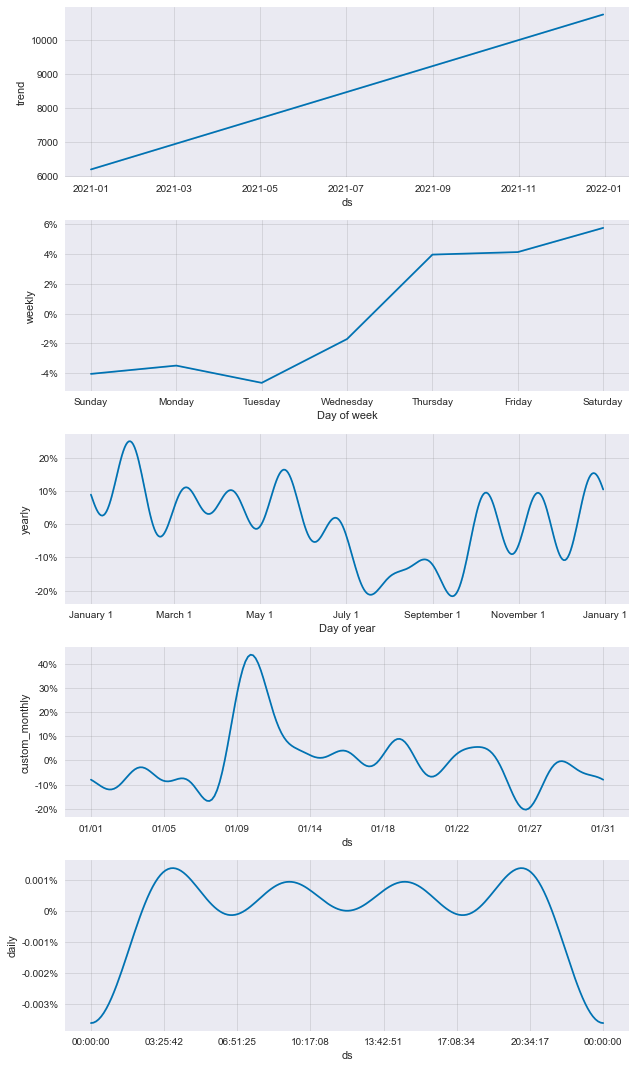

In [597]:
model_15.plot_components(pred_15, uncertainty=True);

---
# Сравнение качества построенных моделей

In [128]:
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score #R^2

---
### Модель 1 (ARMA(1, 1))

In [138]:
print(f'MSE = {mean_squared_error(d21_test_1, pred_1)}')
print(f'MAE = {mean_absolute_error(d21_test_1, pred_1)}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_1, pred_1))}')  
print(f'R^2 = {r2_score(d21_test_1, pred_1)}')

MSE = 3879073.563915912
MAE = 1365.8110733910432
RMSE = 1969.5363829886242
R^2 = -0.029606736799532962


---
### Модель 2 (Начальная Хольта-Винтерса)

In [156]:
print(f'MSE = {mean_squared_error(d21_test_2, pred_2)}')
print(f'MAE = {mean_absolute_error(d21_test_2, pred_2)}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_2, pred_2))}')  
print(f'R^2 = {r2_score(d21_test_2, pred_2)}')

MSE = 3869372.486512148
MAE = 1483.37566021849
RMSE = 1967.0720593084911
R^2 = -0.027031819236214893


---
### Модель 3 (Prophet (без регрессоров))

In [291]:
print(f'MSE = {mean_squared_error(d21_test_3.set_index("ds"), pred_3_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_3.set_index("ds"), pred_3_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_3.set_index("ds"), pred_3_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_3.set_index("ds"), pred_3_plt.set_index("ds")["y"])}')

MSE = 7311358.060868018
MAE = 2346.350859663697
RMSE = 2703.952303733928
R^2 = -0.9406240666969892


---
### Модель 4 (Prophet (с учетом сезонности))

In [292]:
print(f'MSE = {mean_squared_error(d21_test_4.set_index("ds"), pred_4_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_4.set_index("ds"), pred_4_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_4.set_index("ds"), pred_4_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_4.set_index("ds"), pred_4_plt.set_index("ds")["y"])}')

MSE = 2634459.8697160874
MAE = 1259.0671951786464
RMSE = 1623.1019283199953
R^2 = 0.30074601963735736


---
### Модель 5 (Prophet (с регрессором – 15ое число каждого месяца))

In [297]:
print(f'MSE = {mean_squared_error(d21_test_5[["ds", "y"]].set_index("ds"), pred_5_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_5[["ds", "y"]].set_index("ds"), pred_5_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_5[["ds", "y"]].set_index("ds"), pred_5_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_5[["ds", "y"]].set_index("ds"), pred_5_plt.set_index("ds")["y"])}')

MSE = 2134255.5375378816
MAE = 1104.9485299375358
RMSE = 1460.90914759881
R^2 = 0.43351322337841947


---
### Модель 6 (Prophet (с регрессором – 15ое число каждого месяца и учетом сезонности, c отсутствием точек излома тренда))

In [319]:
print(f'MSE = {mean_squared_error(d21_test_6[["ds", "y"]].set_index("ds"), pred_6_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_6[["ds", "y"]].set_index("ds"), pred_6_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_6[["ds", "y"]].set_index("ds"), pred_6_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_6[["ds", "y"]].set_index("ds"), pred_6_plt.set_index("ds")["y"])}')

MSE = 1791135.0747768637
MAE = 1028.7879481443995
RMSE = 1338.332946159835
R^2 = 0.5245862938349343


In [154]:
wape = (d21_test_6['y'] - pred_6_plt['y']).abs().sum() / d21_test_6['y'].sum()
print(wape)

0.12748318882667095


In [153]:
pred_6_plt['y']

273    7166.559840
274    7920.487291
275    7740.468753
276    7472.244648
277    7178.084168
          ...     
360    7955.531043
361    8783.464102
362    9050.989142
363    8271.957758
364    7492.411980
Name: y, Length: 92, dtype: float64

In [151]:
d21_test_6['y']

ds      y  reg1
273 2021-10-01   5596     0
274 2021-10-02   5800     0
275 2021-10-03  10898     0
276 2021-10-04   7340     0
277 2021-10-05   8872     0
..         ...    ...   ...
360 2021-12-27  10699     0
361 2021-12-28  11086     0
362 2021-12-29   9400     0
363 2021-12-30  10043     0
364 2021-12-31   5464     0

[92 rows x 3 columns]

In [155]:
np.mean(np.abs((d21_test_6['y'] - pred_6_plt['y']) / d21_test_6['y'])) * 100

13.41512678349778

---
### Модель 7 (Prophet (с регрессорами – 1ое и 15ое числа каждого месяца и учетом сезонности))

In [341]:
print(f'MSE = {mean_squared_error(d21_test_7[["ds", "y"]].set_index("ds"), pred_7_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_7[["ds", "y"]].set_index("ds"), pred_7_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_7[["ds", "y"]].set_index("ds"), pred_7_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_7[["ds", "y"]].set_index("ds"), pred_7_plt.set_index("ds")["y"])}')

MSE = 2015665.2975853167
MAE = 1108.7219582790997
RMSE = 1419.7412783973411
R^2 = 0.46499014897984414


---
### Модель 8 (Auto-arima (ARIMA(1,0,0)(0,0,3)[30]))

In [502]:
print(f'MSE = {mean_squared_error(d21_test_8, pred_8.set_index("date"))}')
print(f'MAE = {mean_absolute_error(d21_test_8, pred_8.set_index("date"))}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_8, pred_8.set_index("date")))}')  
print(f'R^2 = {r2_score(d21_test_8, pred_8.set_index("date"))}')

MSE = 3642380.5732373972
MAE = 1323.7695241243584
RMSE = 1908.5021805692015
R^2 = 0.03321772211838803


---
### Модель 9 (Auto-arima (SARIMA(1,0,0)(0,0,1)[31]))

In [1002]:
print(f'MSE = {mean_squared_error(d21_test_9, pred_9.set_index("date"))}')
print(f'MAE = {mean_absolute_error(d21_test_9, pred_9.set_index("date"))}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_9, pred_9.set_index("date")))}')  
print(f'R^2 = {r2_score(d21_test_9, pred_9.set_index("date"))}')

MSE = 7079967.501007639
MAE = 1783.833273740958
RMSE = 2660.8208321883753
R^2 = -0.8792070104492704


---
### Модель 10 (Auto-arima (SARIMA(3,0,4)(1,0,1)[31], trend='t' (линейный)))

In [1018]:
print(f'MSE = {mean_squared_error(d21_test_10, pred_10.set_index("date"))}')
print(f'MAE = {mean_absolute_error(d21_test_10, pred_10.set_index("date"))}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_10, pred_10.set_index("date")))}')  
print(f'R^2 = {r2_score(d21_test_10, pred_10.set_index("date"))}')

MSE = 3918996.4450391303
MAE = 1395.8104569357843
RMSE = 1979.6455352004637
R^2 = -0.04020330494386504


---
### Модель 11 (Prophet (с регрессорами – 15ое число каждого месяца и день месяца и учетом сезонности))

In [129]:
print(f'MSE = {mean_squared_error(d21_test_11[["ds", "y"]].set_index("ds"), pred_11_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_11[["ds", "y"]].set_index("ds"), pred_11_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_11[["ds", "y"]].set_index("ds"), pred_11_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_11[["ds", "y"]].set_index("ds"), pred_11_plt.set_index("ds")["y"])}')

MSE = 1976351.7055621773
MAE = 1098.5841513297266
RMSE = 1405.8277652551103
R^2 = 0.4754249959936633


---
### Модель 12 (Prophet (с регрессорами – 15ое число каждого месяца и день недели и учетом сезонности))

In [154]:
print(f'MSE = {mean_squared_error(d21_test_12[["ds", "y"]].set_index("ds"), pred_12_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_12[["ds", "y"]].set_index("ds"), pred_12_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_12[["ds", "y"]].set_index("ds"), pred_12_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_12[["ds", "y"]].set_index("ds"), pred_12_plt.set_index("ds")["y"])}')

MSE = 1871549.8529377508
MAE = 1076.0928106149224
RMSE = 1368.0459981074287
R^2 = 0.5032421259638028


---
### Модель 13 (Prophet (с регрессором – 15ое число каждого месяца, учетом сезонности и праздников))

In [304]:
print(f'MSE = {mean_squared_error(d21_test_13[["ds", "y"]].set_index("ds"), pred_13_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_13[["ds", "y"]].set_index("ds"), pred_13_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_13[["ds", "y"]].set_index("ds"), pred_13_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_13[["ds", "y"]].set_index("ds"), pred_13_plt.set_index("ds")["y"])}')

MSE = 2000786.007889357
MAE = 1081.142851443478
RMSE = 1414.4914308292423
R^2 = 0.46893949839467886


---
### Модель 14 (Базовая LSTM)

In [378]:
print(f'MSE = {mean_squared_error(d21_test_13[["ds", "y"]].set_index("ds"), pred_14_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_13[["ds", "y"]].set_index("ds"), pred_14_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_13[["ds", "y"]].set_index("ds"), pred_14_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_13[["ds", "y"]].set_index("ds"), pred_14_plt.set_index("ds")["y"])}')

MSE = 5910840.3801004235
MAE = 1708.631972115406
RMSE = 2431.2219931755353
R^2 = -0.568890348486836


---
### Модель 15 (Prophet (сезонность+тренд))

In [560]:
print(f'MSE = {mean_squared_error(d21_test_15.set_index("ds")["y"], pred_15_plt.set_index("ds")["y"])}')
print(f'MAE = {mean_absolute_error(d21_test_15.set_index("ds")["y"], pred_15_plt.set_index("ds")["y"])}')
print(f'RMSE = {np.sqrt(mean_squared_error(d21_test_15.set_index("ds")["y"], pred_15_plt.set_index("ds")["y"]))}')  
print(f'R^2 = {r2_score(d21_test_15.set_index("ds")["y"], pred_15_plt.set_index("ds")["y"])}')

MSE = 8636456.012577806
MAE = 2480.2445019222864
RMSE = 2938.7847850051567
R^2 = -1.2923394326263664


---
## Анализ сезонности спроса на товары

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdb1bc22af0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


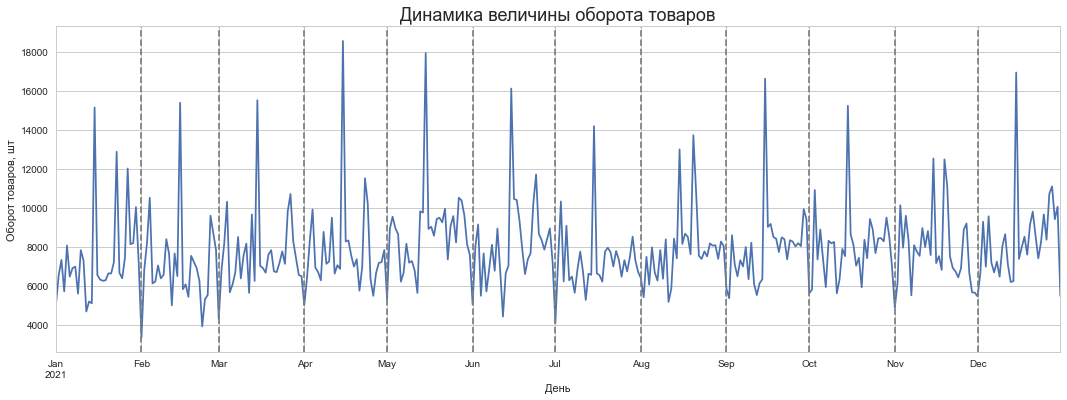

In [547]:
ax = df21.plot(x='date', y='turnoverOfGoods', figsize=(18,6), label='_nolegend_')
xcoords = ['2021-01-01', '2021-02-01','2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', 
            '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01']
for xc in xcoords:
    plt.axvline(x=xc, color='gray', linestyle='--')

plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Динамика величины оборота товаров', size=18);

/Users/dasha/Library/Python/3.9/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:613: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdcbf969f70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


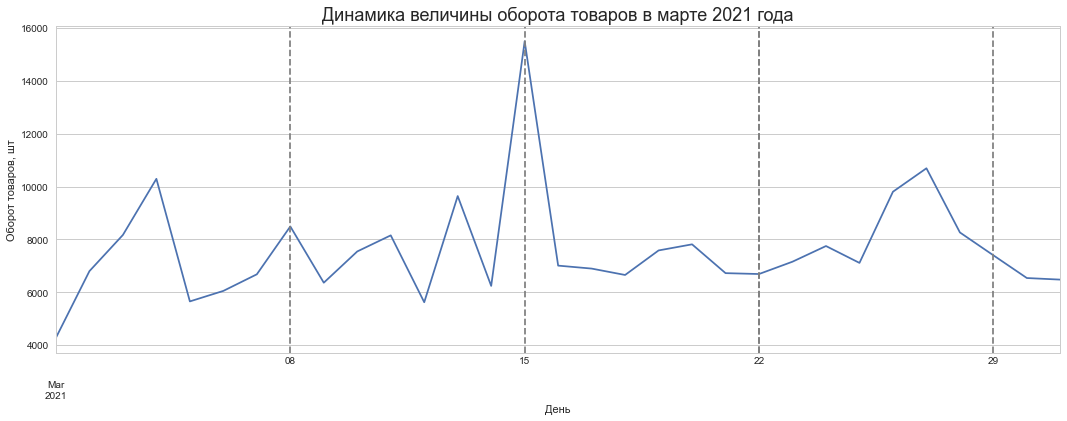

In [563]:
ax = df21[59:90].plot(x='date', y='turnoverOfGoods', figsize=(18,6), label='_nolegend_')
xcoords = ['2021-03-01', '2021-03-08','2021-03-15', '2021-03-22', '2021-03-22', '2021-03-29']
for xc in xcoords:
    plt.axvline(x=xc, color='gray', linestyle='--')

plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Динамика величины оборота товаров в марте 2021 года', size=18);

- ## декомпозиция временного ряда

- по месяцам

<ipython-input-557-2c9adf4136eb>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_M = seasonal_decompose(df21.set_index('date')[['turnoverOfGoods']], model='multiplicative', freq=31)


Text(0.5, 0.98, 'Мультипликативная модель')

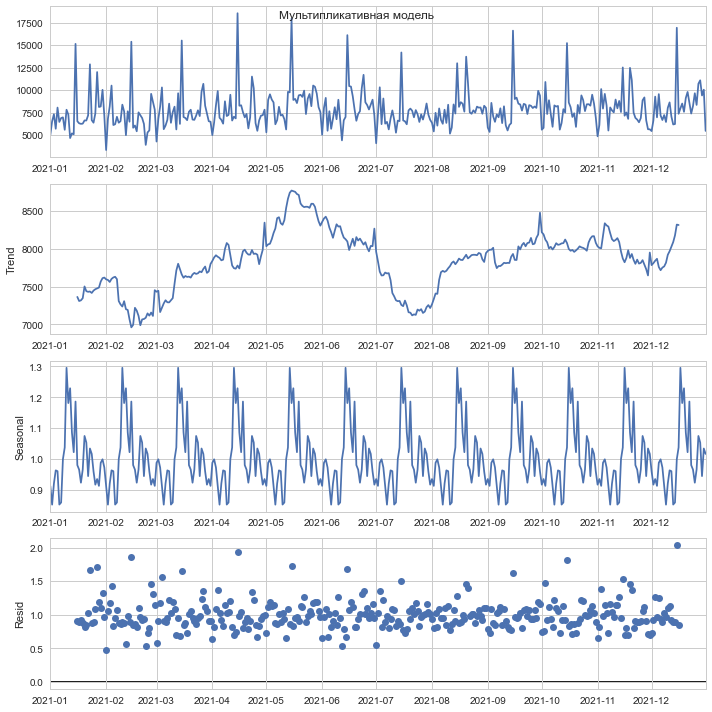

In [557]:
result_M = seasonal_decompose(df21.set_index('date')[['turnoverOfGoods']], model='multiplicative', freq=31)

plt.rcParams.update({'figure.figsize':(10,10)})
result_M.plot().suptitle('Мультипликативная модель')

In [601]:
d21_2 = d21.copy()
d21_2 = d21_2.reset_index(drop=True)

In [602]:
d21_2['day'] = df21['date'].dt.day
d21_2['month'] = df21['date'].dt.month

<AxesSubplot:xlabel='month', ylabel='day'>

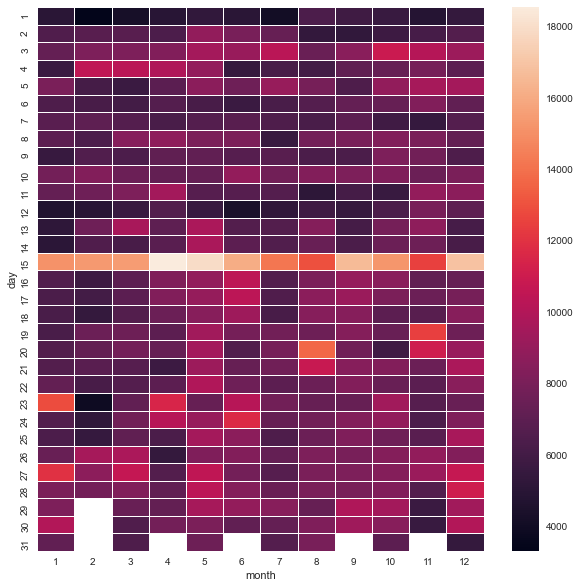

In [603]:
sns.heatmap(d21_2.pivot('day', 'month', 'turnoverOfGoods'), linewidths=.5)

In [134]:
# номер недели в месяце
df21_copy['week'] = df21_copy['date'].dt.isocalendar()['week'] // 12 + 1

<AxesSubplot:xlabel='date'>

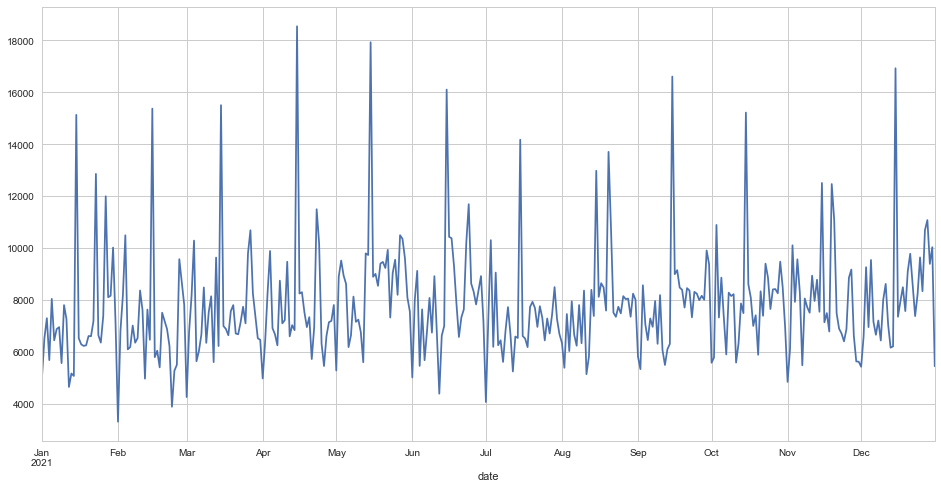

In [159]:
df21.set_index('date')['turnoverOfGoods'].plot()

In [ ]:
# точечный и интервальный прогноз для SARIMAX на h периодов вперед
conf_ins = model_fit.get_forecast(h).summary_frame()

---
## Агрегация по месяцам

In [570]:
df21_agg_m = df21.resample('M', on='date').sum().reset_index()

In [575]:
df21_agg_m

date  turnoverOfGoods
0  2021-01-31           228246
1  2021-02-28           197584
2  2021-03-31           236079
3  2021-04-30           234586
4  2021-05-31           271451
5  2021-06-30           243329
6  2021-07-31           224468
7  2021-08-31           243907
8  2021-09-30           237773
9  2021-10-31           247843
10 2021-11-30           236970
11 2021-12-31           257626

In [578]:
# template = 'plotly_dark', 
fig = px.line(df21_agg_m.rename({'turnoverOfGoods':'Оборот, шт'}, axis=1), x="date", y="Оборот, шт", labels={'value' : 'Оборот товаров, шт', 'date': 'Месяц'})
fig.update_layout(legend_title='', legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),  font=dict(
        family="Arial",
        size=13
    ))
custom_legend_name(['Оборот товаров, шт'])
fig.show()

---
## Агрегация по неделям

In [579]:
df21_agg_w = df21.resample('W', on='date').sum().reset_index()

In [583]:
# template = 'plotly_dark', 
fig = px.line(df21_agg_w.rename({'turnoverOfGoods':'Оборот, шт'}, axis=1), x="date", y="Оборот, шт", labels={'value' : 'Оборот товаров, шт', 'date': 'Неделя'})
fig.update_layout(legend_title='', legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),  font=dict(
        family="Arial",
        size=13
    ))
custom_legend_name(['Оборот товаров, шт'])
fig.show()

In [48]:
data[(data['date'].dt.day == 15) & (data['date'].dt.year == 2021)]

date  product_code  turnoverOfGoods  turnoverWithDisc  \
106251 2021-01-15       7802639              360           35971.4   
106252 2021-01-15       7802641              229           22684.8   
106253 2021-01-15       7802643              197           19531.1   
106254 2021-01-15       7802656              304           30285.5   
106255 2021-01-15       7802657              339           33732.3   
...           ...           ...              ...               ...   
202959 2021-12-15       7829750                6             781.0   
202960 2021-12-15       7830032               14            2434.0   
202961 2021-12-15       7831273                1             377.0   
202962 2021-12-15       7831274                1             379.0   
202963 2021-12-15       7831275                5            1887.6   

        percentOfDisc  
106251          37.89  
106252          38.28  
106253          38.26  
106254          38.10  
106255          38.12  
...               ...  
202959          29.64  
202960          16.70  
202961          15.66  
202962          15.21  
202963          16.17  

[3680 rows x 5 columns]

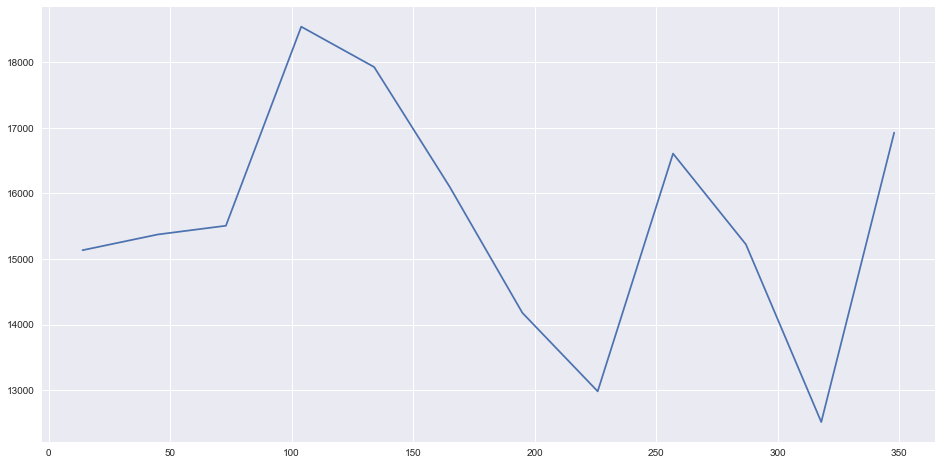

In [62]:
plt.plot(df21[df21['date'].dt.day == 15]['turnoverOfGoods'])

<AxesSubplot:>

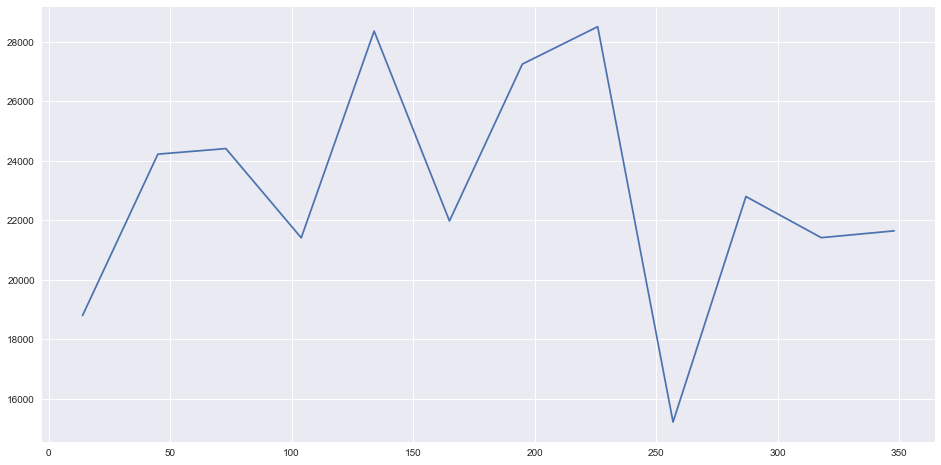

In [54]:
df19[df19['date'].dt.day == 15]['turnoverOfGoods'].plot()

In [66]:
data19 = data[data['date'] < '2020-01-01']

In [68]:
data21 = data[data['date'] > '2020-01-01']

---
Анализ 15го числа (регулярная акция)

In [30]:
df15 = df21[df21['date'].dt.day == 15]

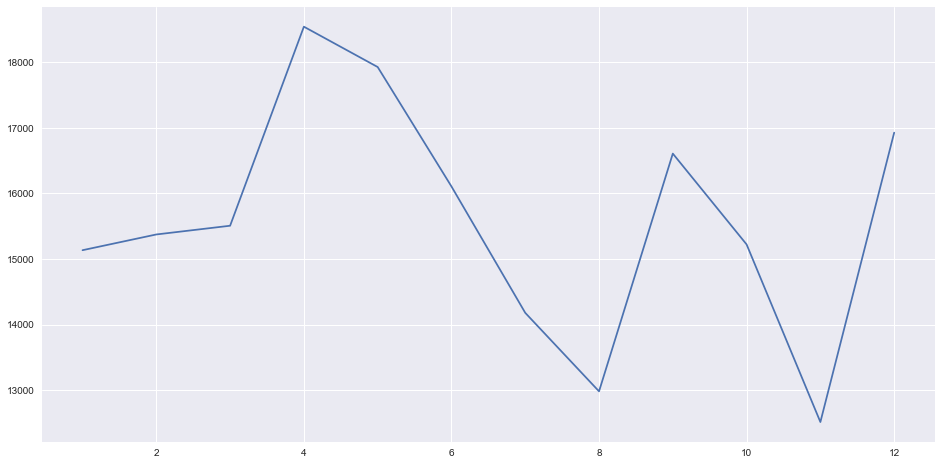

In [40]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], df15['turnoverOfGoods'])

In [45]:
fig = px.line(df15, x="date", y="turnoverOfGoods", labels={'turnoverOfGoods' : 'Оборот товаров, шт', 'date': 'Месяц'})
fig.update_layout(legend_title='', legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),  font=dict(
        family="Arial",
        size=13
    ))
custom_legend_name(['Оборот товаров, шт'])
fig.show()

In [46]:
test = sm.tsa.adfuller(df15['turnoverOfGoods'])
print(f'adf: {round(test[0], 4)}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -2.5232
p-value: 0.10993633821316556
Critical values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
есть единичные корни, ряд не стационарен


---
## Анализ коррелограмм (автокорреляция и частичная автокорреляция)

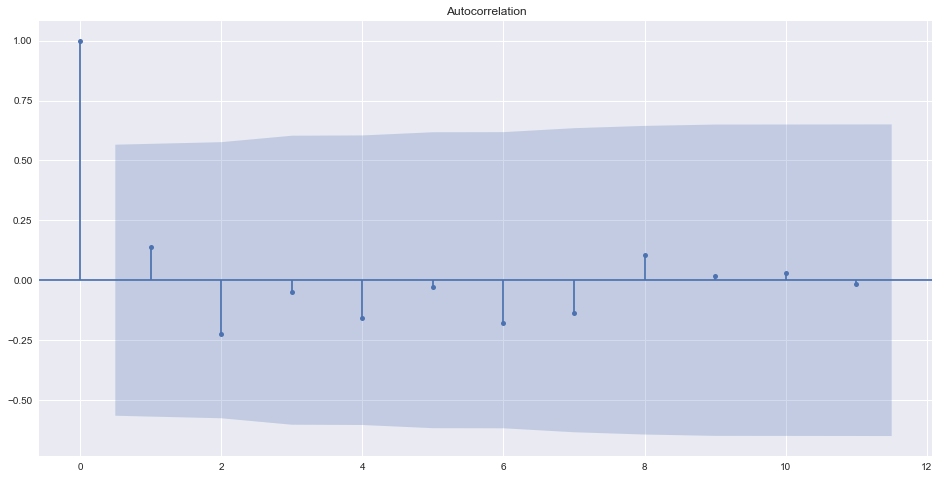

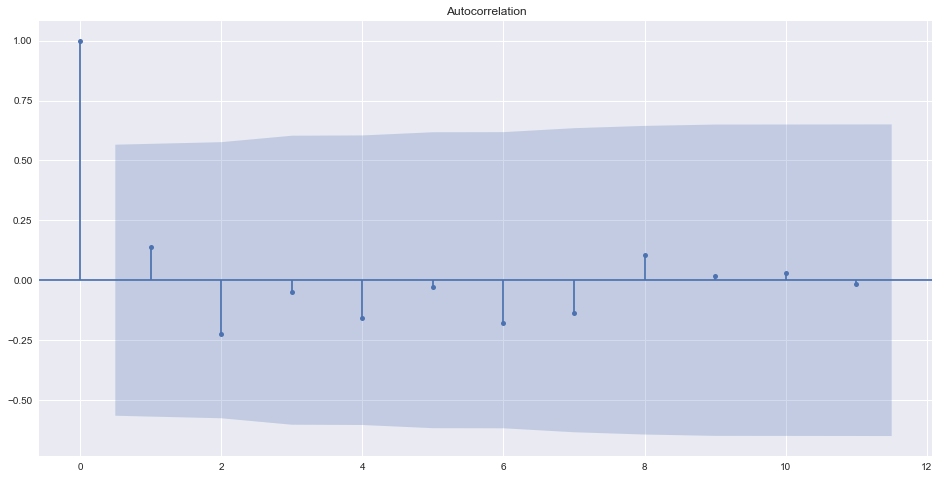

In [50]:
plot_acf(df15['turnoverOfGoods'], lags=11)

In [63]:
model_15_1 = auto_arima(df15.set_index('date'), start_p=0, start_q=0, test='adf', max_p=6,
                            max_q=6,
                            trace=True, error_action='ignore', 
                            supress_warnings=True, stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=193.758, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=195.491, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=194.323, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=195.614, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.093 seconds


In [55]:
model_15_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -95.879
Date:                Sun, 17 Apr 2022   AIC                            193.758
Time:                        19:02:37   BIC                            194.061
Sample:                             0   HQIC                           193.426
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.215e+07   5.97e+06      2.035      0.042    4.47e+05    2.38e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.39   Prob(JB):                         0.82
Heteroskedasticity (H):               3.56   Skew:                             0.38
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
model_15_1 = sm.tsa.statespace.SARIMAX(df15.set_index('date'), order=(0, 2, 0))
model_15_1 = model_15_1.fit()
print(model_15_1.summary())

                               SARIMAX Results                                
Dep. Variable:        turnoverOfGoods   No. Observations:                   12
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -95.879
Date:                Sun, 17 Apr 2022   AIC                            193.758
Time:                        19:15:04   BIC                            194.061
Sample:                             0   HQIC                           193.426
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.215e+07   5.97e+06      2.035      0.042    4.47e+05    2.38e+07
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.39   Pr

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



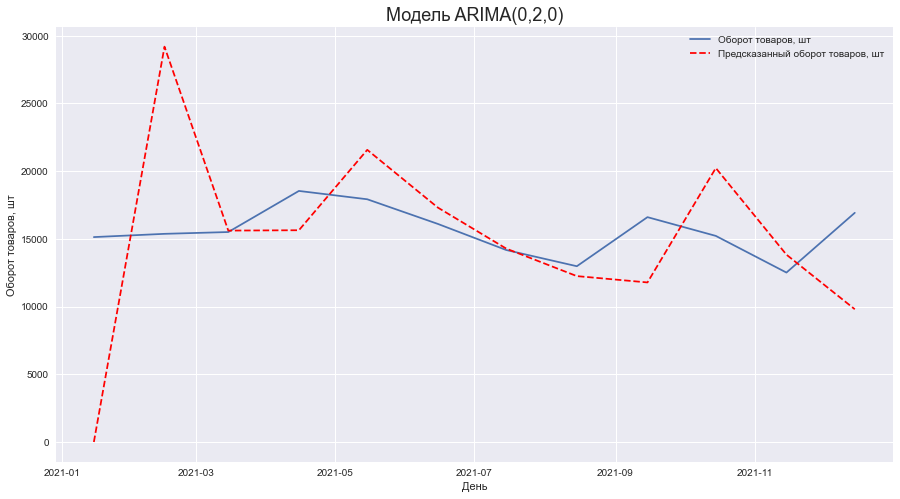

In [68]:
plt.figure(figsize=(15, 8))
plt.plot(df15['date'], df15['turnoverOfGoods']);
plt.plot(model_15_1.fittedvalues, 'r--');
plt.legend(['Оборот товаров, шт', 'Предсказанный оборот товаров, шт'])
plt.xlabel('День')
plt.ylabel('Оборот товаров, шт')
plt.title('Модель ARIMA(0,2,0)', size=18);